In [ ]:
from google.colab import drive
drive.mount('/content/MyDrive/')

Drive already mounted at /content/MyDrive/; to attempt to forcibly remount, call drive.mount("/content/MyDrive/", force_remount=True).


# Feature Extraction

In [ ]:
import numpy as np
import pandas as pd
from pathlib import Path
from skimage import io, color, feature, measure, filters
from skimage.util import img_as_ubyte
from tqdm import tqdm
import torch

class MangoFeatureExtractor:
    """A wrapper class to extract shape, color (LAB, HSV), and edge features from mango images using scikit-image,
       with GPU-accelerated statistics via PyTorch when available."""

    def __init__(self, image_dir, output_dir=None):
        """
        Initialize the feature extractor.

        Args:
            image_dir (str): Directory containing train and val folders with mango images.
            output_dir (str, optional): Directory to save CSV files. Defaults to image_dir.
        """
        self.image_dir = Path(image_dir)
        self.output_dir = Path(output_dir) if output_dir else self.image_dir
        self.output_dir.mkdir(parents=True, exist_ok=True)

        # pick up GPU if available
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"[*] Using device: {self.device}")

        # Define CSV file paths
        self.csv_files = {
            'train': {
                'lab': self.output_dir / 'train_LAB.csv',
                'hsv': self.output_dir / 'train_HSV.csv',
                'shape': self.output_dir / 'train_Shape_features.csv',
                'edge': self.output_dir / 'train_Edge_features.csv'
            },
            'val': {
                'lab': self.output_dir / 'val_LAB.csv',
                'hsv': self.output_dir / 'val_HSV.csv',
                'shape': self.output_dir / 'val_Shape_features.csv',
                'edge': self.output_dir / 'val_Edge_features.csv'
            }
        }

        # Initialize CSV files with headers
        self._initialize_csv_files()

    def _initialize_csv_files(self):
        """Initialize empty CSV files with headers for each feature type."""
        lab_headers   = ['image_name', 'LAB_L_mean', 'LAB_L_std', 'LAB_A_mean', 'LAB_A_std', 'LAB_B_mean', 'LAB_B_std', 'target']
        hsv_headers   = ['image_name', 'HSV_H_mean', 'HSV_H_std', 'HSV_S_mean', 'HSV_S_std', 'HSV_V_mean', 'HSV_V_std', 'target']
        shape_headers = ['image_name', 'area', 'perimeter', 'aspect_ratio', 'eccentricity', 'target']
        edge_headers  = ['image_name', 'edge_density', 'edge_intensity_mean', 'edge_intensity_std', 'target']

        for dataset in ['train', 'val']:
            pd.DataFrame(columns=lab_headers).to_csv(self.csv_files[dataset]['lab'], index=False)
            pd.DataFrame(columns=hsv_headers).to_csv(self.csv_files[dataset]['hsv'], index=False)
            pd.DataFrame(columns=shape_headers).to_csv(self.csv_files[dataset]['shape'], index=False)
            pd.DataFrame(columns=edge_headers).to_csv(self.csv_files[dataset]['edge'], index=False)

    def extract_features(self):
        """Process all images in the train and val directories and save features dynamically to CSV."""
        valid_extensions = ('.jpg', '.jpeg', '.png')

        for dataset in ['train', 'val']:
            dataset_path = self.image_dir / dataset
            if not dataset_path.exists():
                print(f"Directory not found: {dataset_path}")
                continue

            total_images = sum(
                1 for variety_path in dataset_path.iterdir() if variety_path.is_dir()
                for image_path in variety_path.glob("*") if image_path.suffix.lower() in valid_extensions
            )
            progress_bar = tqdm(total=total_images, desc=f"Processing {dataset} images")

            for variety_path in dataset_path.iterdir():
                if not variety_path.is_dir():
                    continue
                variety = variety_path.name

                for image_path in variety_path.glob("*"):
                    if image_path.suffix.lower() not in valid_extensions:
                        continue
                    try:
                        image = io.imread(image_path)
                        if image is None:
                            print(f"Failed to load image: {image_path}")
                            progress_bar.update(1)
                            continue
                        if image.shape[-1] == 4:  # RGBA -> RGB
                            image = image[..., :3]

                        # Extract features
                        lab   = self._extract_lab_features(image, image_path.name, variety)
                        hsv   = self._extract_hsv_features(image, image_path.name, variety)
                        shape = self._extract_shape_features(image, image_path.name, variety)
                        edge  = self._extract_edge_features(image, image_path.name, variety)

                        # Save to CSV
                        self._save_features_to_csv(dataset, lab, hsv, shape, edge)
                        progress_bar.update(1)

                    except Exception as e:
                        print(f"Error processing image {image_path}: {e}")
                        progress_bar.update(1)
                        continue

            progress_bar.close()

        print(f"Features saved to {self.output_dir}")

    def _save_features_to_csv(self, dataset, lab, hsv, shape, edge):
        """Append features to the corresponding CSV files."""
        pd.DataFrame([lab]).to_csv(self.csv_files[dataset]['lab'], mode='a', header=False, index=False)
        pd.DataFrame([hsv]).to_csv(self.csv_files[dataset]['hsv'], mode='a', header=False, index=False)
        pd.DataFrame([shape]).to_csv(self.csv_files[dataset]['shape'], mode='a', header=False, index=False)
        pd.DataFrame([edge]).to_csv(self.csv_files[dataset]['edge'], mode='a', header=False, index=False)

    def _extract_lab_features(self, image, image_name, target):
        lab_image = color.rgb2lab(image)
        l, a, b = lab_image[...,0], lab_image[...,1], lab_image[...,2]

        lt = torch.from_numpy(l.astype(np.float32)).to(self.device)
        at = torch.from_numpy(a.astype(np.float32)).to(self.device)
        bt = torch.from_numpy(b.astype(np.float32)).to(self.device)

        return {
            'image_name':   image_name,
            'LAB_L_mean':   lt.mean().item(),
            'LAB_L_std':    lt.std().item(),
            'LAB_A_mean':   at.mean().item(),
            'LAB_A_std':    at.std().item(),
            'LAB_B_mean':   bt.mean().item(),
            'LAB_B_std':    bt.std().item(),
            'target':       target
        }

    def _extract_hsv_features(self, image, image_name, target):
        hsv_image = color.rgb2hsv(image)
        h, s, v = hsv_image[...,0], hsv_image[...,1], hsv_image[...,2]

        ht = torch.from_numpy(h.astype(np.float32)).to(self.device)
        st = torch.from_numpy(s.astype(np.float32)).to(self.device)
        vt = torch.from_numpy(v.astype(np.float32)).to(self.device)

        return {
            'image_name':   image_name,
            'HSV_H_mean':   ht.mean().item(),
            'HSV_H_std':    ht.std().item(),
            'HSV_S_mean':   st.mean().item(),
            'HSV_S_std':    st.std().item(),
            'HSV_V_mean':   vt.mean().item(),
            'HSV_V_std':    vt.std().item(),
            'target':       target
        }

    def _extract_shape_features(self, image, image_name, target):
        gray = color.rgb2gray(image)
        thresh = filters.threshold_otsu(gray)
        binary = gray > thresh
        labeled = measure.label(binary)
        regions = measure.regionprops(labeled)

        if not regions:
            return {
                'image_name':   image_name,
                'area':         0,
                'perimeter':    0,
                'aspect_ratio': 0,
                'eccentricity': 0,
                'target':       target
            }

        region = max(regions, key=lambda r: r.area)
        area       = region.area
        perimeter  = region.perimeter
        aspect     = region.major_axis_length / region.minor_axis_length if region.minor_axis_length > 0 else 0
        eccentric  = region.eccentricity

        return {
            'image_name':   image_name,
            'area':         area,
            'perimeter':    perimeter,
            'aspect_ratio': aspect,
            'eccentricity': eccentric,
            'target':       target
        }

    def _extract_edge_features(self, image, image_name, target):
        gray = color.rgb2gray(image)
        edges = feature.canny(gray, sigma=1.0)

        edge_density = np.sum(edges) / edges.size
        gray_u = img_as_ubyte(gray)
        edge_vals = gray_u[edges]

        if edge_vals.size > 0:
            et = torch.from_numpy(edge_vals.astype(np.float32)).to(self.device)
            mean_int = et.mean().item()
            std_int  = et.std().item()
        else:
            mean_int = 0
            std_int  = 0

        return {
            'image_name':           image_name,
            'edge_density':         edge_density,
            'edge_intensity_mean':  mean_int,
            'edge_intensity_std':   std_int,
            'target':               target
        }

if __name__ == "__main__":
    image_dir  = "/content/MyDrive/MyDrive/Feature_extaction/organized_dataset(80,20)"
    output_dir = "/content/MyDrive/MyDrive/Feature_extaction/FE_data"
    extractor = MangoFeatureExtractor(image_dir, output_dir)
    extractor.extract_features()


[*] Using device: cuda


Processing val images: 100%|██████████| 507/507 [17:51<00:00,  2.11s/it]

Features saved to /content/MyDrive/MyDrive/Feature_extaction/FE_data


# Using different combination of feature selection

In [ ]:
from google.colab import drive
drive.mount('/content/MyDrive/')

Mounted at /content/MyDrive/


Dropped 124 rows with target in ['malgova']. New dataset size: (1642, 20)
Best CV accuracy (after dropping ['malgova']): 0.8569
Best feature subset: ['edge_intensity_mean', 'HSV_S_mean', 'HSV_S_std', 'LAB_L_mean', 'LAB_L_std', 'LAB_A_mean', 'LAB_B_std', 'area']


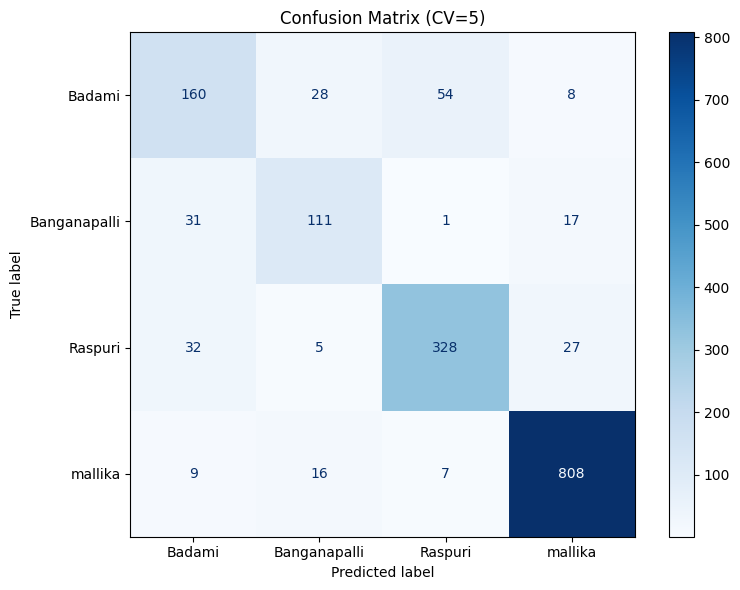

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
import matplotlib.pyplot as plt

# --- PARAMETERS ---
csv_path       = '/content/MyDrive/MyDrive/Feature_extaction/train_no_outliers.csv'
target_col     = 'target'
drop_cols      = ['image_name']
remove_classes = ['malgova']   # <-- now we drop the class named "malgova"
n_clusters     = 5
k_neighbors    = 5
cv_folds       = 5
max_features   = 19

# --- LOAD DATA ---
df = pd.read_csv(csv_path).drop(columns=drop_cols, errors='ignore')

# --- REMOVE SPECIFIED CLASSES ---
if remove_classes:
    # Keep only rows whose target is NOT in remove_classes
    before = df.shape[0]
    df = df[~df[target_col].isin(remove_classes)]
    after = df.shape[0]
    print(f"Dropped {before - after} rows with target in {remove_classes}. New dataset size: {df.shape}")

# --- SPLIT FEATURES / TARGET ---
X = df.drop(columns=[target_col])
y = df[target_col]

# --- BUILD PIPELINE ---
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("kmeans", KMeans(n_clusters=n_clusters, random_state=42)),
    ("knn",    KNeighborsClassifier(n_neighbors=k_neighbors))
])

# --- FEATURE SELECTION WITH SFS ---
sfs = SFS(
    estimator=pipe,
    k_features=(1, max_features),
    forward=True,
    floating=False,
    scoring='accuracy',
    cv=cv_folds,
    n_jobs=-1
)
sfs = sfs.fit(X, y)

# --- EXTRACT BEST FEATURES & SCORE ---
best_idx   = list(sfs.k_feature_idx_)
best_feats = [X.columns[i] for i in best_idx]
best_score = sfs.k_score_
print(f"Best CV accuracy (after dropping {remove_classes}): {best_score:.4f}")
print("Best feature subset:", best_feats)

# --- RE-FIT PIPELINE & CONFUSION MATRIX ---
X_best = X[best_feats]
pipe.fit(X_best, y)

# Cross‐validated predictions
y_pred = cross_val_predict(pipe, X_best, y, cv=cv_folds, n_jobs=-1)

# Confusion matrix
cm   = confusion_matrix(y, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=pipe.named_steps['knn'].classes_)

fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax, cmap=plt.cm.Blues)
ax.set_title(f'Confusion Matrix (CV={cv_folds})')
plt.tight_layout()
plt.show()


64% : badami (250) ,69% : bagananpalli (160), 83% : Raspuri (392), 96%: mallika (840), 46%: malgova(124)

In [ ]:
import pandas as pd
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from collections import Counter

# Load the dataset (replace 'your_dataset.csv' with your actual file path)
data = pd.read_csv('/content/MyDrive/MyDrive/Feature_extaction/train_no_outliers.csv')

# Separate features and target
# Assuming the dataset has 'image_name', feature columns, and 'target'
X = data.drop(['image_name', 'target'], axis=1)  # Features
y = data['target']  # Target labels

# Define the target number of samples per class
target_samples = 404

# Define the sampling strategy for SMOTE (oversampling minority classes)
# Original counts: malgova (124), bagananpalli (160), badami (250), Raspuri (392), mallika (840)
sampling_strategy_over = {
    'malgova': target_samples,
    'Banganapalli': target_samples,
    'Badami': target_samples,
    'Raspuri': target_samples
}

# Define the sampling strategy for RandomUnderSampler (undersampling majority class)
sampling_strategy_under = {
    'mallika': target_samples
}

# Create a pipeline to apply SMOTE followed by random undersampling
pipeline = Pipeline([
    ('over', SMOTE(sampling_strategy=sampling_strategy_over)),
    ('under', RandomUnderSampler(sampling_strategy=sampling_strategy_under))
])

# Apply the pipeline to balance the dataset
X_balanced, y_balanced = pipeline.fit_resample(X, y)

# Combine the balanced features and target into a DataFrame
balanced_data = pd.DataFrame(X_balanced, columns=X.columns)
balanced_data['target'] = y_balanced

# Save the balanced dataset to a new CSV file
balanced_data.to_csv('/content/MyDrive/MyDrive/Feature_extaction/FE_data/balanced_dataset.csv', index=False)

# Verify the class distribution after balancing
print("Class distribution after balancing:", Counter(y_balanced))

Class distribution after balancing: Counter({'Badami': 404, 'Banganapalli': 404, 'Raspuri': 404, 'malgova': 404, 'mallika': 404})


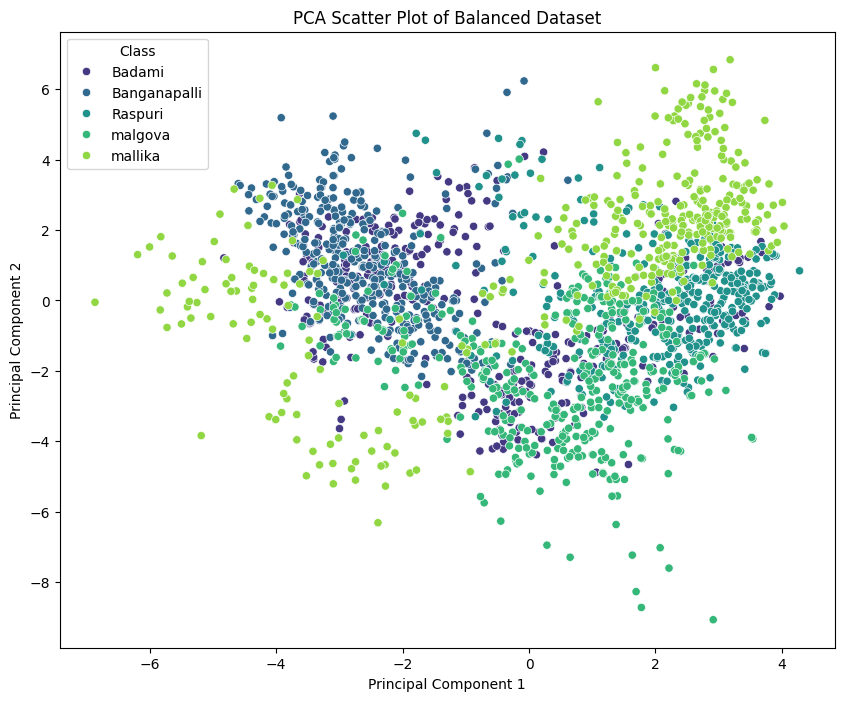

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Standardize the balanced features
X_balanced = pd.read_csv('/content/MyDrive/MyDrive/Feature_extaction/FE_data/balanced_dataset.csv')
y_balanced = X_balanced['target']
X_balanced = X_balanced.drop(columns=['target'])
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_balanced)

# Apply PCA to reduce to 2 dimensions
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Create a DataFrame for plotting
pca_df = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2'])
pca_df['target'] = y_balanced

# Plot the scatter plot using seaborn
plt.figure(figsize=(10, 8))
sns.scatterplot(x='PC1', y='PC2', hue='target', data=pca_df, palette='viridis')
plt.title('PCA Scatter Plot of Balanced Dataset')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Class')
plt.show()

Dropped 404 rows with target in ['Badami']. New dataset size: (1616, 20)
Best CV accuracy (after dropping ['Badami']''): 0.8861
Best feature subset: ['edge_density', 'edge_intensity_std', 'HSV_S_std', 'LAB_L_std', 'LAB_A_mean', 'LAB_A_std', 'LAB_B_mean', 'LAB_B_std', 'area']


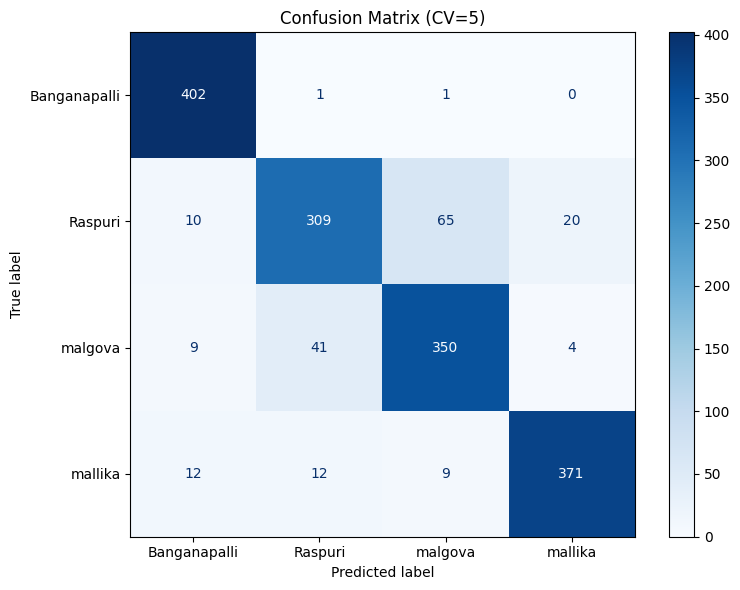

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
import matplotlib.pyplot as plt

# --- PARAMETERS ---
csv_path       = '/content/MyDrive/MyDrive/Feature_extaction/FE_data/balanced_dataset.csv'
target_col     = 'target'
drop_cols      = ['image_name']
remove_classes = ['Badami']   # <-- now we drop the class named "malgova"
n_clusters     = 4
k_neighbors    = 5
cv_folds       = 5
max_features   = 19

# --- LOAD DATA ---
df = pd.read_csv(csv_path).drop(columns=drop_cols, errors='ignore')

# --- REMOVE SPECIFIED CLASSES ---
if remove_classes:
    # Keep only rows whose target is NOT in remove_classes
    before = df.shape[0]
    df = df[~df[target_col].isin(remove_classes)]
    after = df.shape[0]
    print(f"Dropped {before - after} rows with target in {remove_classes}. New dataset size: {df.shape}")

# --- SPLIT FEATURES / TARGET ---
X = df.drop(columns=[target_col])
y = df[target_col]

# --- BUILD PIPELINE ---
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("kmeans", KMeans(n_clusters=n_clusters, random_state=42)),
    ("knn",    KNeighborsClassifier(n_neighbors=k_neighbors))
])

# --- FEATURE SELECTION WITH SFS ---
sfs = SFS(
    estimator=pipe,
    k_features=(1, max_features),
    forward=True,
    floating=False,
    scoring='accuracy',
    cv=cv_folds,
    n_jobs=-1
)
sfs = sfs.fit(X, y)

# --- EXTRACT BEST FEATURES & SCORE ---
best_idx   = list(sfs.k_feature_idx_)
best_feats = [X.columns[i] for i in best_idx]
best_score = sfs.k_score_
print(f"Best CV accuracy (after dropping {remove_classes}''): {best_score:.4f}")
print("Best feature subset:", best_feats)

# --- RE-FIT PIPELINE & CONFUSION MATRIX ---
X_best = X[best_feats]
pipe.fit(X_best, y)

# Cross‐validated predictions
y_pred = cross_val_predict(pipe, X_best, y, cv=cv_folds, n_jobs=-1)

# Confusion matrix
cm   = confusion_matrix(y, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=pipe.named_steps['knn'].classes_)

fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax, cmap=plt.cm.Blues)
ax.set_title(f'Confusion Matrix (CV={cv_folds})')
plt.tight_layout()
plt.show()


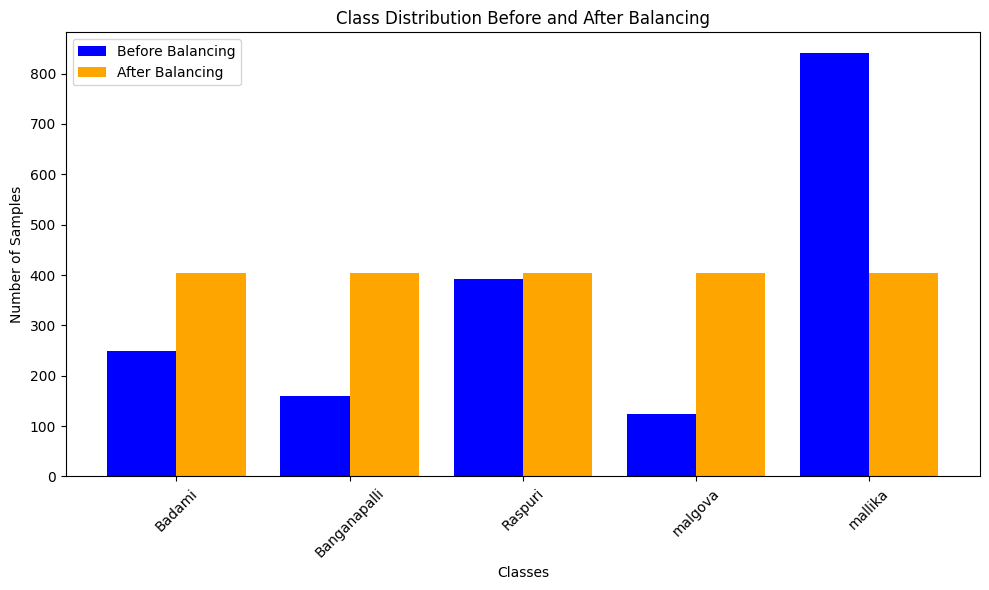

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import sys


original_path = '/content/MyDrive/MyDrive/Feature_extaction/train_no_outliers.csv'
balanced_path = '/content/MyDrive/MyDrive/Feature_extaction/FE_data/balanced_dataset.csv'

# Read the original and balanced datasets
original_df = pd.read_csv(original_path)
balanced_df = pd.read_csv(balanced_path)

# Count the number of samples per class
original_counts = original_df['target'].value_counts()
balanced_counts = balanced_df['target'].value_counts()

# Get sorted list of class names
classes = sorted(list(original_counts.index))

# Get counts for before and after balancing
before_counts = [original_counts[cls] for cls in classes]
after_counts = [balanced_counts[cls] for cls in classes]

# Number of classes
N = len(classes)

# Positions for the bars
before_positions = list(range(N))
after_positions = [i + 0.4 for i in range(N)]

# Create the plot
plt.figure(figsize=(10, 6))
plt.bar(before_positions, before_counts, width=0.4, label='Before Balancing', color='blue')
plt.bar(after_positions, after_counts, width=0.4, label='After Balancing', color='orange')

# Set x-ticks to be in the middle of the groups
plt.xticks([i + 0.2 for i in range(N)], classes, rotation=45)

# Add labels and title
plt.xlabel('Classes')
plt.ylabel('Number of Samples')
plt.title('Class Distribution Before and After Balancing')
plt.legend()

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys

original_path = '/content/MyDrive/MyDrive/Feature_extaction/train_no_outliers.csv'
balanced_path = '/content/MyDrive/MyDrive/Feature_extaction/FE_data/balanced_dataset.csv'

# Read the original and balanced datasets
original_df = pd.read_csv(original_path)
balanced_df = pd.read_csv(balanced_path)

# Separate features and target
X_original = original_df.drop(['image_name', 'target'], axis=1)
y_original = original_df['target']
X_balanced = balanced_df.drop(['target'], axis=1)
y_balanced = balanced_df['target']

# Add target back to feature DataFrames for class-wise plotting
original_df_with_target = X_original.copy()
original_df_with_target['target'] = y_original
balanced_df_with_target = X_balanced.copy()
balanced_df_with_target['target'] = y_balanced

# Get unique classes and feature names
classes = sorted(list(set(y_original)))
features = X_original.columns

# Set up the plot grid: rows = features, columns = classes, with original and balanced side by side
fig, axes = plt.subplots(nrows=len(features), ncols=len(classes) * 2, figsize=(6 * len(classes) * 2, 4 * len(features)), sharey='row')

for i, feature in enumerate(features):
    for j, cls in enumerate(classes):
        # Original data
        original_class_data = original_df_with_target[original_df_with_target['target'] == cls][feature]
        sns.kdeplot(original_class_data, ax=axes[i, j * 2], label=f'Original {cls}', color='blue', fill=True, alpha=0.3)
        axes[i, j * 2].set_title(f'Original - {cls} - {feature}')
        axes[i, j * 2].set_xlabel(feature)
        if j == 0:
            axes[i, j * 2].set_ylabel('Density')
        axes[i, j * 2].legend()

        # Balanced data
        balanced_class_data = balanced_df_with_target[balanced_df_with_target['target'] == cls][feature]
        sns.kdeplot(balanced_class_data, ax=axes[i, j * 2 + 1], label=f'Balanced {cls}', color='orange', fill=True, alpha=0.3)
        axes[i, j * 2 + 1].set_title(f'Balanced - {cls} - {feature}')
        axes[i, j * 2 + 1].set_xlabel(feature)
        if j == 0:
            axes[i, j * 2 + 1].set_ylabel('Density')
        axes[i, j * 2 + 1].legend()

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.

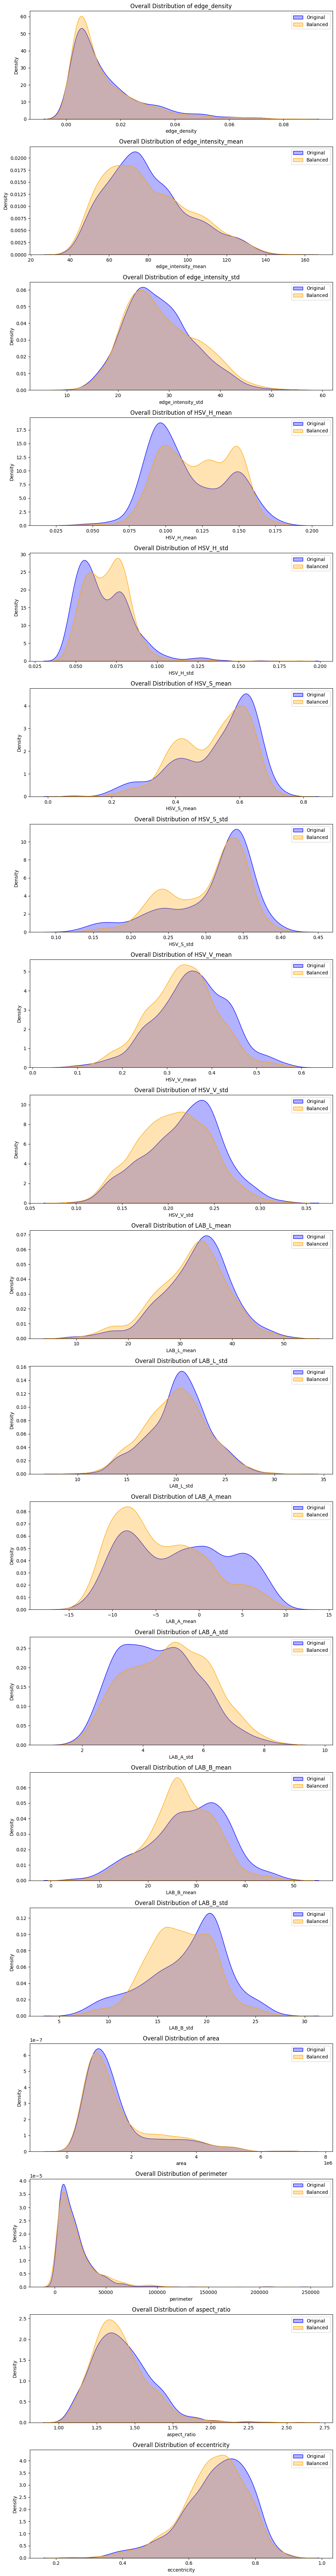

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

original_path = '/content/MyDrive/MyDrive/Feature_extaction/train_no_outliers.csv'
balanced_path = '/content/MyDrive/MyDrive/Feature_extaction/FE_data/balanced_dataset.csv'

# Read the original and balanced datasets
original_df = pd.read_csv(original_path)
balanced_df = pd.read_csv(balanced_path)

# Separate features
X_original = original_df.drop(['image_name', 'target'], axis=1)
X_balanced = balanced_df.drop(['target'], axis=1)

# Get feature names
features = X_original.columns

# Set up the plot grid: one row per feature
fig, axes = plt.subplots(nrows=len(features), ncols=1, figsize=(10, 4 * len(features)), sharey=False)

# Ensure axes is iterable even for a single feature
if len(features) == 1:
    axes = [axes]

for i, feature in enumerate(features):
    # Plot overall distribution for original data
    sns.kdeplot(X_original[feature], ax=axes[i], label='Original', color='blue', fill=True, alpha=0.3)
    # Plot overall distribution for balanced data
    sns.kdeplot(X_balanced[feature], ax=axes[i], label='Balanced', color='orange', fill=True, alpha=0.3)
    axes[i].set_title(f'Overall Distribution of {feature}')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Density')
    axes[i].legend()

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

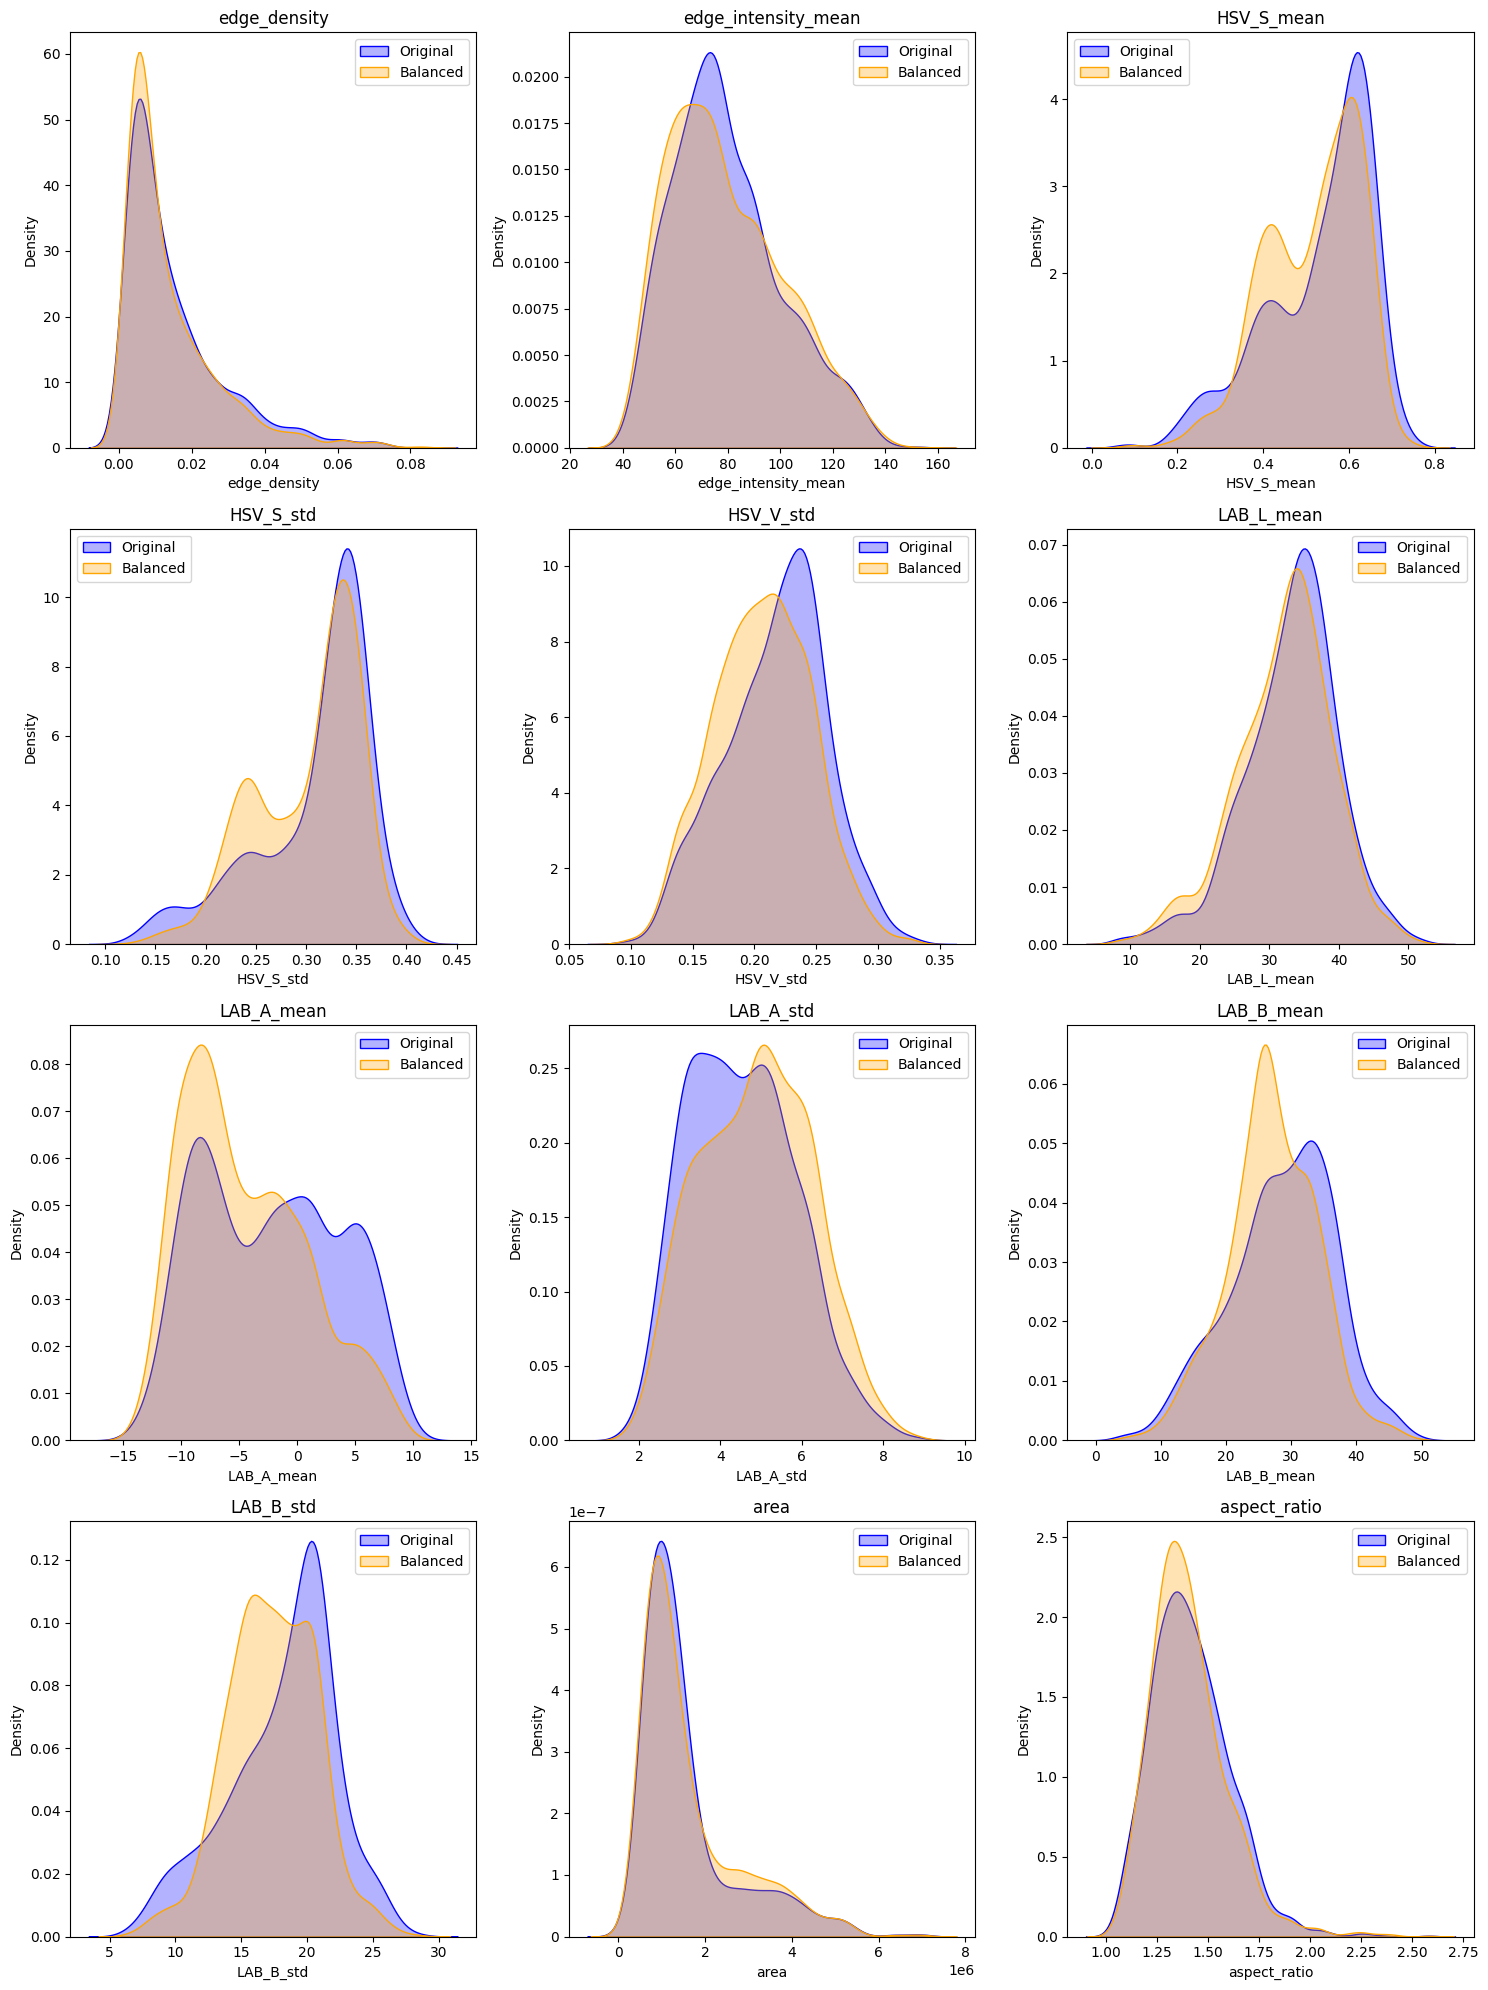

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Paths to the datasets
original_path = '/content/MyDrive/MyDrive/Feature_extaction/train_no_outliers.csv'
balanced_path = '/content/MyDrive/MyDrive/Feature_extaction/FE_data/balanced_dataset.csv'

# Load the datasets
original_df = pd.read_csv(original_path)
balanced_df = pd.read_csv(balanced_path)

# Define the features to plot
features_to_plot = [
    'edge_density', 'edge_intensity_mean', 'HSV_S_mean', 'HSV_S_std', 'HSV_V_std',
    'LAB_L_mean', 'LAB_A_mean', 'LAB_A_std', 'LAB_B_mean', 'LAB_B_std', 'area', 'aspect_ratio'
]

# Select the features from the datasets
X_original = original_df[features_to_plot]
X_balanced = balanced_df[features_to_plot]

# Create a 4x3 grid of subplots
fig, axes = plt.subplots(4, 3, figsize=(15, 20))

# Iterate over the axes and features
for ax, feature in zip(axes.flat, features_to_plot):
    # Plot KDE for original dataset
    sns.kdeplot(X_original[feature], ax=ax, label='Original', color='blue', fill=True, alpha=0.3)
    # Plot KDE for balanced dataset
    sns.kdeplot(X_balanced[feature], ax=ax, label='Balanced', color='orange', fill=True, alpha=0.3)
    # Customize the plot
    ax.set_title(feature)
    ax.set_xlabel(feature)
    ax.set_ylabel('Density')
    ax.legend()

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

# k-means , DBSCAN, GMM

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, cross_val_predict, GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
import matplotlib.pyplot as plt
import numpy as np

# --- PARAMETERS ---
csv_path       = '/content/MyDrive/MyDrive/Feature_extaction/FE_data/balanced_dataset.csv'
target_col     = 'target'
drop_cols      = []
remove_classes = ['Badami']
cv_folds       = 5
max_features   = 19

# --- LOAD DATA ---
df = pd.read_csv(csv_path).drop(columns=drop_cols)

# --- REMOVE SPECIFIED CLASSES ---
if remove_classes:
    before = df.shape[0]
    df = df[~df[target_col].isin(remove_classes)]
    after = df.shape[0]
    print(f"Dropped {before - after} rows with target in {remove_classes}. New dataset size: {df.shape}")

# --- SPLIT FEATURES / TARGET ---
X = df.drop(columns=[target_col])
y = df[target_col]

# --- PREPROCESS WITH CLUSTERING ---
def apply_clustering(X, method='gmm', n_clusters=4, random_state=42):
    if method == 'kmeans':
        clusterer = KMeans(n_clusters=n_clusters, random_state=random_state)
    elif method == 'gmm':
        clusterer = GaussianMixture(n_components=n_clusters, random_state=random_state)
    else:
        raise ValueError("Method must be 'kmeans' or 'gmm'")
    cluster_labels = clusterer.fit_predict(X)
    # Convert cluster labels to one-hot encoded features
    cluster_features = np.zeros((X.shape[0], n_clusters))
    cluster_features[np.arange(X.shape[0]), cluster_labels] = 1
    # Combine original features with cluster features
    X_processed = np.hstack((X.values, cluster_features))
    # Define column names for the new DataFrame
    orig_cols = X.columns.tolist()
    cluster_cols = [f'cluster_{i}' for i in range(n_clusters)]
    all_cols = orig_cols + cluster_cols
    return pd.DataFrame(X_processed, columns=all_cols)

X_kmeans = apply_clustering(X, method='kmeans', n_clusters=4)
X_gmm = apply_clustering(X, method='gmm', n_clusters=4)

# --- DEFINE PIPELINES ---
pipe_kmeans = Pipeline([
    ("scaler", StandardScaler()),
    ("knn", KNeighborsClassifier())
])

pipe_gmm = Pipeline([
    ("scaler", StandardScaler()),
    ("knn", KNeighborsClassifier())
])

# --- PARAMETER GRIDS FOR TUNING ---
param_grid_kmeans = {
    'knn__n_neighbors': [4, 5, 7, 10],
    'knn__weights': ['uniform', 'distance']
}

param_grid_gmm = {
    'knn__n_neighbors': [4, 5, 7, 10],
    'knn__weights': ['uniform', 'distance']
}

# --- FEATURE SELECTION WITH SFS ---
def run_sfs(pipeline, param_grid, X, y):
    sfs = SFS(
        estimator=pipeline,
        k_features=(1, max_features),
        forward=True,
        floating=False,
        scoring='accuracy',
        cv=cv_folds,
        n_jobs=-1
    )
    sfs = sfs.fit(X, y)
    best_idx = list(sfs.k_feature_idx_)
    best_feats = [X.columns[i] for i in best_idx]
    return best_feats, sfs.k_score_

# --- GRID SEARCH FUNCTION ---
def run_grid_search(pipeline, param_grid, X, y):
    grid_search = GridSearchCV(pipeline, param_grid, cv=cv_folds, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X, y)
    return grid_search.best_params_, grid_search.best_score_

# --- RUN EXPERIMENTS ---
clustering_methods = [
    ("K-means", X_kmeans, pipe_kmeans, param_grid_kmeans),
    ("GMM", X_gmm, pipe_gmm, param_grid_gmm)
]

for name, X_processed, pipeline, param_grid in clustering_methods:
    print(f"\n--- Experimenting with {name} ---")

    # Feature Selection
    best_feats, sfs_score = run_sfs(pipeline, param_grid, X_processed, y)
    X_best = X_processed[best_feats]
    print(f"Best features for {name}: {best_feats}")
    print(f"SFS CV accuracy: {sfs_score:.4f}")

    # Hyperparameter Tuning
    best_params, best_score = run_grid_search(pipeline, param_grid, X_best, y)
    print(f"Best parameters for {name}: {best_params}")
    print(f"Best CV accuracy for {name}: {best_score:.4f}")

    # Fit pipeline with best parameters and generate confusion matrix
    pipeline.set_params(**best_params)
    pipeline.fit(X_best, y)
    y_pred = cross_val_predict(pipeline, X_best, y, cv=cv_folds, n_jobs=-1)

    # Confusion Matrix
    cm = confusion_matrix(y, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipeline.named_steps['knn'].classes_)

    fig, ax = plt.subplots(figsize=(8, 6))
    disp.plot(ax=ax, cmap=plt.cm.Blues)
    ax.set_title(f'Confusion Matrix for {name} (CV={cv_folds})')
    plt.tight_layout()
    plt.savefig(f'confusion_matrix_{name.lower()}.png')
    plt.close()

Dropped 404 rows with target in ['Badami']. New dataset size: (1616, 20)

--- Experimenting with K-means ---
Best features for K-means: ['edge_density', 'edge_intensity_std', 'HSV_H_mean', 'HSV_S_mean', 'HSV_S_std', 'HSV_V_std', 'LAB_L_std', 'LAB_A_mean', 'LAB_B_mean', 'LAB_B_std', 'area', 'perimeter', 'aspect_ratio']
SFS CV accuracy: 0.9449
Best parameters for K-means: {'knn__n_neighbors': 5, 'knn__weights': 'distance'}
Best CV accuracy for K-means: 0.9530

--- Experimenting with GMM ---
Best features for GMM: ['edge_density', 'edge_intensity_std', 'HSV_H_mean', 'HSV_S_mean', 'HSV_S_std', 'HSV_V_std', 'LAB_L_std', 'LAB_A_mean', 'LAB_B_mean', 'LAB_B_std', 'area', 'perimeter', 'aspect_ratio']
SFS CV accuracy: 0.9449
Best parameters for GMM: {'knn__n_neighbors': 5, 'knn__weights': 'distance'}
Best CV accuracy for GMM: 0.9530


In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, cross_val_predict, GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
import matplotlib.pyplot as plt
import numpy as np

# --- PARAMETERS ---
csv_path       = '/content/MyDrive/MyDrive/Feature_extaction/FE_data/balanced_dataset.csv'
target_col     = 'target'
drop_cols      = []
remove_classes = ['Badami']
cv_folds       = 5
max_features   = 19

# --- LOAD DATA ---
df = pd.read_csv(csv_path).drop(columns=drop_cols)

# --- REMOVE SPECIFIED CLASSES ---
if remove_classes:
    before = df.shape[0]
    df = df[~df[target_col].isin(remove_classes)]
    after = df.shape[0]
    print(f"Dropped {before - after} rows with target in {remove_classes}. New dataset size: {df.shape}")

# --- SPLIT FEATURES / TARGET ---
X = df.drop(columns=[target_col])
y = df[target_col]

# --- PREPROCESS WITH CLUSTERING ---
def apply_clustering(X, method='kmeans', n_clusters=4, random_state=42):
    if method == 'kmeans':
        clusterer = KMeans(n_clusters=n_clusters, random_state=random_state)
    elif method == 'gmm':
        clusterer = GaussianMixture(n_components=n_clusters, random_state=random_state)
    else:
        raise ValueError("Method must be 'kmeans' or 'gmm'")
    cluster_labels = clusterer.fit_predict(X)
    # Use raw cluster labels as a new feature instead of one-hot encoding
    X_processed = np.hstack((X.values, cluster_labels.reshape(-1, 1)))
    orig_cols = X.columns.tolist()
    cluster_col = [f'cluster_label']
    all_cols = orig_cols + cluster_col
    return pd.DataFrame(X_processed, columns=all_cols)

# Test different n_clusters
n_clusters_options = [3, 4, 5]
X_kmeans_list = [apply_clustering(X, method='kmeans', n_clusters=n) for n in n_clusters_options]
X_gmm_list = [apply_clustering(X, method='gmm', n_clusters=n) for n in n_clusters_options]

# --- DEFINE PIPELINES ---
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("knn", KNeighborsClassifier())
])

# --- PARAMETER GRID FOR TUNING ---
param_grid = {
    'knn__n_neighbors': [4, 5, 7, 10],
    'knn__weights': ['uniform', 'distance'],
    'knn__p': [1, 2]  # Add distance metric variation
}

# --- FEATURE SELECTION WITH SFS ---
def run_sfs(pipeline, param_grid, X, y):
    sfs = SFS(
        estimator=pipeline,
        k_features=(1, max_features),
        forward=True,
        floating=False,
        scoring='accuracy',
        cv=cv_folds,
        n_jobs=-1
    )
    sfs = sfs.fit(X, y)
    best_idx = list(sfs.k_feature_idx_)
    best_feats = [X.columns[i] for i in best_idx]
    return best_feats, sfs.k_score_

# --- GRID SEARCH FUNCTION ---
def run_grid_search(pipeline, param_grid, X, y):
    grid_search = GridSearchCV(pipeline, param_grid, cv=cv_folds, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X, y)
    return grid_search.best_params_, grid_search.best_score_

# --- RUN EXPERIMENTS ---
for name, X_list in [("K-means", X_kmeans_list), ("GMM", X_gmm_list)]:
    for i, X_processed in enumerate(X_list):
        n_clusters = n_clusters_options[i]
        print(f"\n--- Experimenting with {name} (n_clusters={n_clusters}) ---")

        # Feature Selection
        best_feats, sfs_score = run_sfs(pipe, param_grid, X_processed, y)
        X_best = X_processed[best_feats]
        print(f"Best features for {name} (n={n_clusters}): {best_feats}")
        print(f"SFS CV accuracy: {sfs_score:.4f}")

        # Hyperparameter Tuning
        best_params, best_score = run_grid_search(pipe, param_grid, X_best, y)
        print(f"Best parameters for {name} (n={n_clusters}): {best_params}")
        print(f"Best CV accuracy for {name} (n={n_clusters}): {best_score:.4f}")

        # Fit pipeline with best parameters and generate confusion matrix
        pipe.set_params(**best_params)
        pipe.fit(X_best, y)
        y_pred = cross_val_predict(pipe, X_best, y, cv=cv_folds, n_jobs=-1)

        # Confusion Matrix
        cm = confusion_matrix(y, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipe.named_steps['knn'].classes_)

        fig, ax = plt.subplots(figsize=(8, 6))
        disp.plot(ax=ax, cmap=plt.cm.Blues)
        ax.set_title(f'Confusion Matrix for {name} (n={n_clusters}, CV={cv_folds})')
        plt.tight_layout()
        plt.savefig(f'confusion_matrix_{name.lower()}_n{n_clusters}.png')
        plt.close()

Dropped 404 rows with target in ['Badami']. New dataset size: (1616, 20)

--- Experimenting with K-means (n_clusters=3) ---
Best features for K-means (n=3): ['edge_density', 'edge_intensity_std', 'HSV_H_mean', 'HSV_S_mean', 'HSV_S_std', 'HSV_V_std', 'LAB_L_std', 'LAB_A_mean', 'LAB_B_mean', 'LAB_B_std', 'area', 'perimeter', 'aspect_ratio']
SFS CV accuracy: 0.9449
Best parameters for K-means (n=3): {'knn__n_neighbors': 4, 'knn__p': 1, 'knn__weights': 'distance'}
Best CV accuracy for K-means (n=3): 0.9561

--- Experimenting with K-means (n_clusters=4) ---
Best features for K-means (n=4): ['edge_density', 'edge_intensity_std', 'HSV_H_std', 'HSV_S_mean', 'HSV_S_std', 'HSV_V_mean', 'HSV_V_std', 'LAB_L_std', 'LAB_A_mean', 'LAB_B_mean', 'LAB_B_std', 'area', 'perimeter', 'aspect_ratio']
SFS CV accuracy: 0.9579
Best parameters for K-means (n=4): {'knn__n_neighbors': 4, 'knn__p': 1, 'knn__weights': 'distance'}
Best CV accuracy for K-means (n=4): 0.9579

--- Experimenting with K-means (n_clusters=

Selected features: ['edge_density', 'edge_intensity_std', 'HSV_H_mean', 'HSV_H_std', 'HSV_S_mean', 'HSV_S_std', 'HSV_V_mean', 'HSV_V_std', 'LAB_L_mean', 'LAB_A_mean', 'LAB_B_mean', 'LAB_B_std', 'area', 'perimeter', 'aspect_ratio', 'cluster_label']
SFS CV score: 0.8465
Best KNN params: {'n_neighbors': 5, 'p': 1, 'weights': 'distance'}
Best TRAIN CV accuracy: 0.8772
Validation accuracy: 0.8022


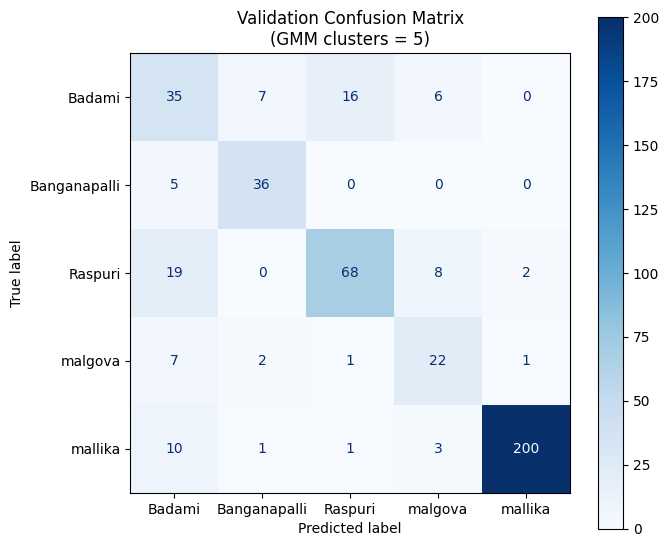

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
# --- PARAMETERS ---
train_csv       = '/content/MyDrive/MyDrive/Feature_extaction/FE_data/balanced_dataset.csv'
val_csv         = '/content/MyDrive/MyDrive/Feature_extaction/val_no_outliers.csv'
target_col      = 'target'
drop_cols       = []                # any cols to drop up front
remove_classes  = []        # classes to remove entirely
n_clusters      = 5                # desired GMM components
random_state    = 42
cv_folds        = 5
max_features    = 19                # upper bound for SFS

# --- DATA LOADING & FILTERING ---
def load_and_filter(path):
    df = pd.read_csv(path).drop(columns=drop_cols)
    if remove_classes:
        df = df[~df[target_col].isin(remove_classes)]
    return df

df_train = load_and_filter(train_csv)
df_val   = load_and_filter(val_csv)

X_train = df_train.drop(columns=[target_col])
y_train = df_train[target_col]

X_val   = df_val.drop(columns=['target','image_name'])
y_val   = df_val[target_col]

# --- SCALER: fit on TRAIN, apply to both ---
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_val_scaled   = scaler.transform(X_val)

# --- GMM: fit on TRAIN, predict labels for both ---
gmm = GaussianMixture(n_components=n_clusters,
                      covariance_type='full',
                      random_state=random_state)
gmm.fit(X_train_scaled)

train_clusters = gmm.predict(X_train_scaled)
val_clusters   = gmm.predict(X_val_scaled)

# append cluster-label as new column
X_train_aug = np.hstack([X_train_scaled, train_clusters.reshape(-1,1)])
X_val_aug   = np.hstack([X_val_scaled,   val_clusters.reshape(-1,1)])

# build column names
orig_cols = X_train.columns.tolist()
all_cols  = orig_cols + ['cluster_label']

X_train_df = pd.DataFrame(X_train_aug, columns=all_cols)
X_val_df   = pd.DataFrame(X_val_aug,   columns=all_cols)


# --- FEATURE SELECTION on TRAIN only ---
knn_base = KNeighborsClassifier()
sfs = SFS(estimator=knn_base,
          k_features=(1, max_features),
          forward=True,
          floating=False,
          scoring='accuracy',
          cv=cv_folds,
          n_jobs=-1)

sfs = sfs.fit(X_train_df, y_train)
selected_idx   = list(sfs.k_feature_idx_)
selected_feats = [all_cols[i] for i in selected_idx]

print("Selected features:", selected_feats)
print(f"SFS CV score: {sfs.k_score_:.4f}")

# subselect columns
X_train_sel = X_train_df[selected_feats]
X_val_sel   = X_val_df[selected_feats]


# --- GRID SEARCH for KNN on TRAIN ---
param_grid = {
    'n_neighbors': [4,5,7,10],
    'weights':     ['uniform','distance'],
    'p':           [1,2]
}

grid = GridSearchCV(KNeighborsClassifier(),
                    param_grid,
                    cv=cv_folds,
                    scoring='accuracy',
                    n_jobs=-1)
grid.fit(X_train_sel, y_train)

print("Best KNN params:", grid.best_params_)
print(f"Best TRAIN CV accuracy: {grid.best_score_:.4f}")


# --- FINAL EVALUATION on VALIDATION SET ---
knn_final = grid.best_estimator_
y_val_pred = knn_final.predict(X_val_sel)
val_acc = accuracy_score(y_val, y_val_pred)
print(f"Validation accuracy: {val_acc:.4f}")
cm = confusion_matrix(y_val, y_val_pred, labels=knn_final.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=knn_final.classes_)

fig, ax = plt.subplots(figsize=(7,6))
disp.plot(ax=ax, cmap=plt.cm.Blues)
ax.set_title(f'Validation Confusion Matrix\n(GMM clusters = {n_clusters})')
plt.tight_layout()
plt.show()


Selected features: ['edge_density', 'edge_intensity_std', 'HSV_H_mean', 'HSV_S_mean', 'HSV_S_std', 'HSV_V_mean', 'HSV_V_std', 'LAB_L_std', 'LAB_A_mean', 'LAB_B_mean', 'LAB_B_std', 'area', 'perimeter', 'aspect_ratio']
SFS CV score: 0.9369
Best KNN params: {'n_neighbors': 4, 'p': 1, 'weights': 'distance'}
Best TRAIN CV accuracy: 0.9530
Validation accuracy: 0.9275


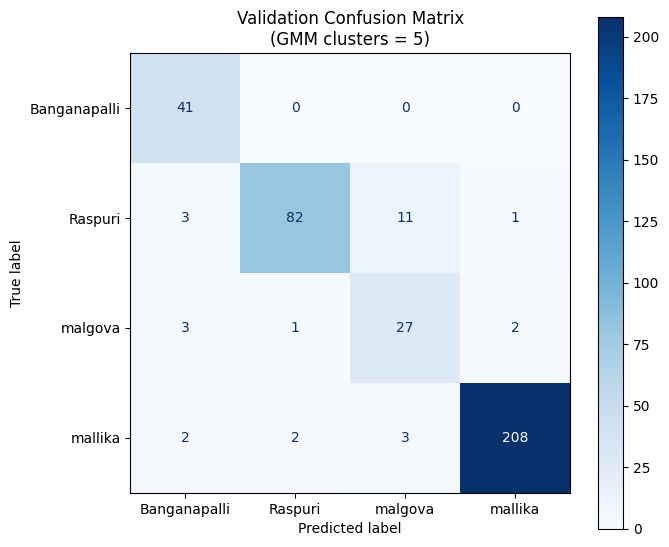

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
# --- PARAMETERS ---
train_csv       = '/content/MyDrive/MyDrive/Feature_extaction/FE_data/balanced_dataset.csv'
val_csv         = '/content/MyDrive/MyDrive/Feature_extaction/val_no_outliers.csv'
target_col      = 'target'
drop_cols       = []                # any cols to drop up front
remove_classes  = ['Badami']        # classes to remove entirely
n_clusters      = 5                # desired GMM components
random_state    = 42
cv_folds        = 4
max_features    = 19                # upper bound for SFS

# --- DATA LOADING & FILTERING ---
def load_and_filter(path):
    df = pd.read_csv(path).drop(columns=drop_cols)
    if remove_classes:
        df = df[~df[target_col].isin(remove_classes)]
    return df

df_train = load_and_filter(train_csv)
df_val   = load_and_filter(val_csv)

X_train = df_train.drop(columns=[target_col])
y_train = df_train[target_col]

X_val   = df_val.drop(columns=['target','image_name'])
y_val   = df_val[target_col]

# --- SCALER: fit on TRAIN, apply to both ---
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_val_scaled   = scaler.transform(X_val)

# --- GMM: fit on TRAIN, predict labels for both ---
gmm = GaussianMixture(n_components=n_clusters,
                      covariance_type='full',
                      random_state=random_state)
gmm.fit(X_train_scaled)

train_clusters = gmm.predict(X_train_scaled)
val_clusters   = gmm.predict(X_val_scaled)

# append cluster-label as new column
X_train_aug = np.hstack([X_train_scaled, train_clusters.reshape(-1,1)])
X_val_aug   = np.hstack([X_val_scaled,   val_clusters.reshape(-1,1)])

# build column names
orig_cols = X_train.columns.tolist()
all_cols  = orig_cols + ['cluster_label']

X_train_df = pd.DataFrame(X_train_aug, columns=all_cols)
X_val_df   = pd.DataFrame(X_val_aug,   columns=all_cols)


# --- FEATURE SELECTION on TRAIN only ---
knn_base = KNeighborsClassifier()
sfs = SFS(estimator=knn_base,
          k_features=(1, max_features),
          forward=True,
          floating=False,
          scoring='accuracy',
          cv=cv_folds,
          n_jobs=-1)

sfs = sfs.fit(X_train_df, y_train)
selected_idx   = list(sfs.k_feature_idx_)
selected_feats = [all_cols[i] for i in selected_idx]

print("Selected features:", selected_feats)
print(f"SFS CV score: {sfs.k_score_:.4f}")

# subselect columns
X_train_sel = X_train_df[selected_feats]
X_val_sel   = X_val_df[selected_feats]


# --- GRID SEARCH for KNN on TRAIN ---
param_grid = {
    'n_neighbors': [4,5,7,10],
    'weights':     ['uniform','distance'],
    'p':           [1,2]
}

grid = GridSearchCV(KNeighborsClassifier(),
                    param_grid,
                    cv=cv_folds,
                    scoring='accuracy',
                    n_jobs=-1)
grid.fit(X_train_sel, y_train)

print("Best KNN params:", grid.best_params_)
print(f"Best TRAIN CV accuracy: {grid.best_score_:.4f}")


# --- FINAL EVALUATION on VALIDATION SET ---
knn_final = grid.best_estimator_
y_val_pred = knn_final.predict(X_val_sel)
val_acc = accuracy_score(y_val, y_val_pred)
print(f"Validation accuracy: {val_acc:.4f}")
cm = confusion_matrix(y_val, y_val_pred, labels=knn_final.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=knn_final.classes_)

fig, ax = plt.subplots(figsize=(7,6))
disp.plot(ax=ax, cmap=plt.cm.Blues)
ax.set_title(f'Validation Confusion Matrix\n(GMM clusters = {n_clusters})')
plt.tight_layout()
plt.show()


In [ ]:
from google.colab import drive
drive.mount('/content/MyDrive')

Mounted at /content/MyDrive


Selected features: ['edge_density', 'edge_intensity_std', 'HSV_H_mean', 'HSV_H_std', 'HSV_S_mean', 'HSV_S_std', 'HSV_V_std', 'LAB_L_std', 'LAB_A_mean', 'LAB_B_mean', 'LAB_B_std', 'area', 'perimeter', 'eccentricity']
14
SFS CV score: 0.9443
Best KNN params: {'n_neighbors': 4, 'p': 1, 'weights': 'distance'}
Best TRAIN CV accuracy: 0.9592
Validation accuracy: 0.9223


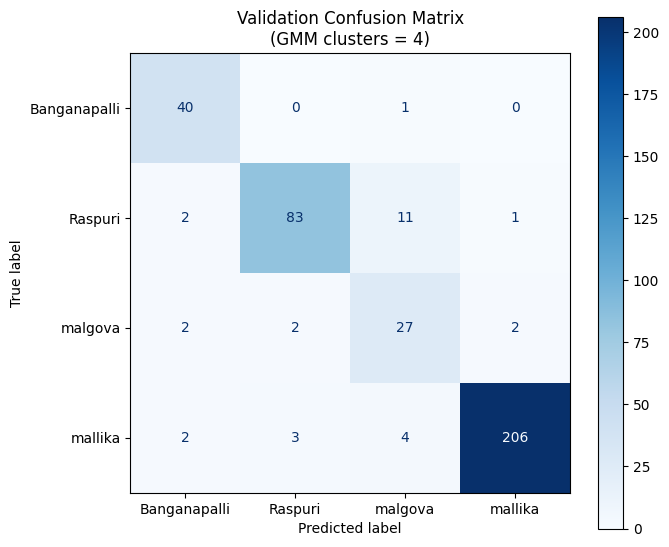

Model saved to /Users/ranjanumeshrao/Downloads/DAL_Lab/Mango/5CLASS_CLUSTERING/Guassian_Mixture_Model/gmm_knn_model_final.joblib
Metadata saved to /Users/ranjanumeshrao/Downloads/DAL_Lab/Mango/5CLASS_CLUSTERING/Guassian_Mixture_Model/gmm_knn_metadata_final.joblib

Performing inference on validation data...
Inference Accuracy: 0.9223


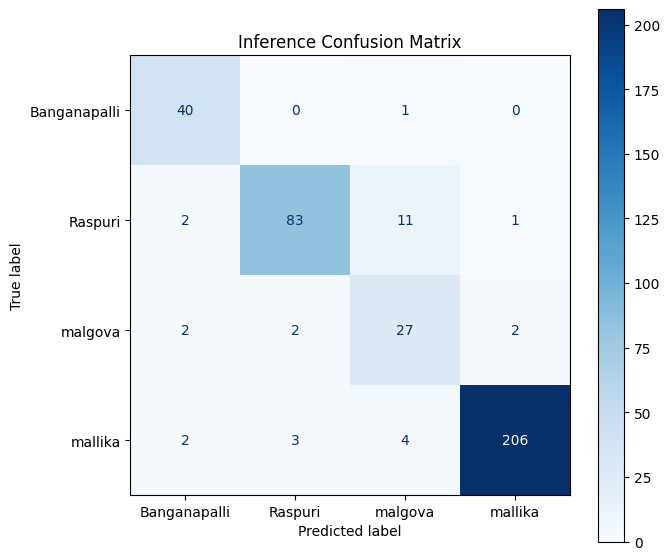

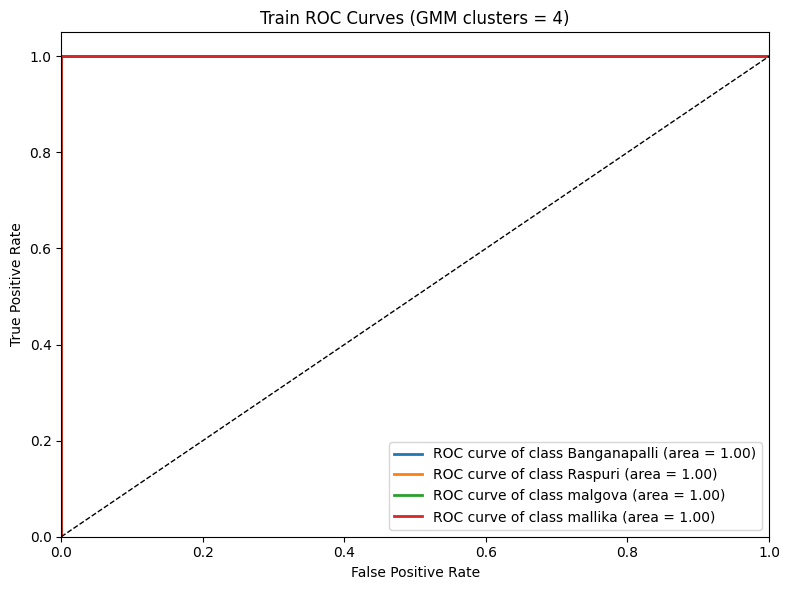

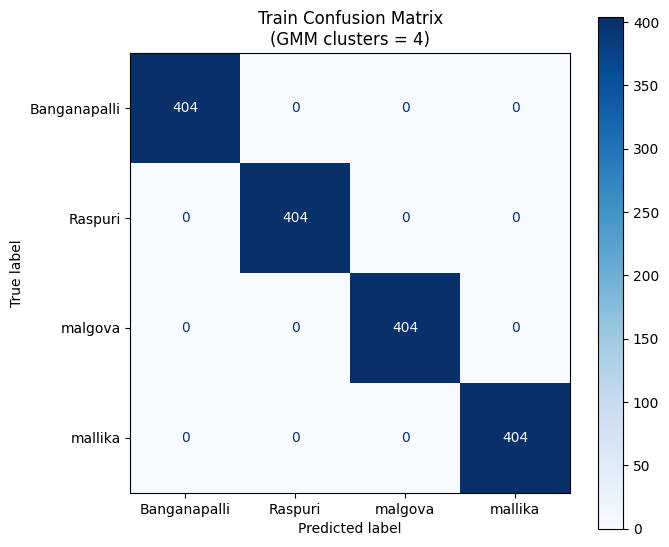

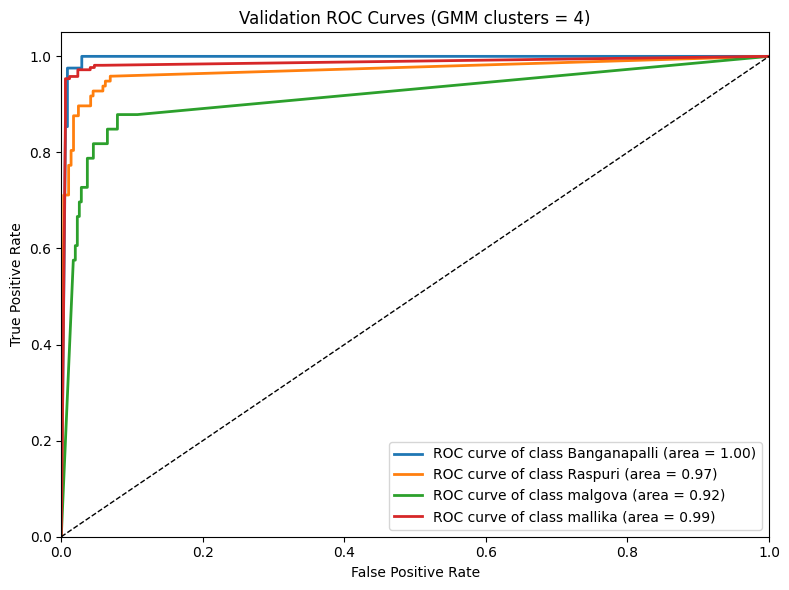

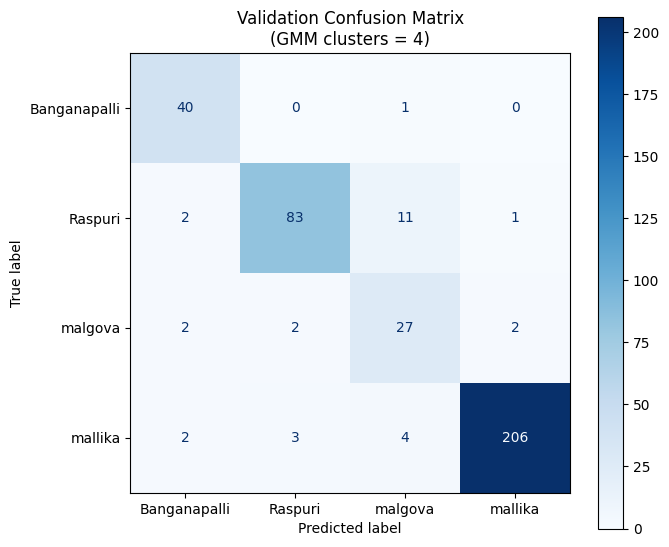

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
import matplotlib.pyplot as plt
import joblib
import os
from sklearn.metrics import roc_curve, auc, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# --- PARAMETERS ---
train_csv       = '/Users/ranjanumeshrao/Downloads/DAL_Lab/Mango/5CLASS_CLUSTERING/data/FE_data/train_balanced_dataset.csv'
val_csv         = '/Users/ranjanumeshrao/Downloads/DAL_Lab/Mango/5CLASS_CLUSTERING/data/FE_data/val_no_outliers.csv'
target_col      = 'target'
drop_cols       = []                # any cols to drop up front
remove_classes  = ['Badami']        # classes to remove entirely
n_clusters      = 4                # desired GMM components
random_state    = 42
cv_folds        = 5
max_features    = 19             # upper bound for SFS
model_save_path = '/Users/ranjanumeshrao/Downloads/DAL_Lab/Mango/5CLASS_CLUSTERING/Guassian_Mixture_Model/gmm_knn_model_final.joblib'
metadata_save_path = '/Users/ranjanumeshrao/Downloads/DAL_Lab/Mango/5CLASS_CLUSTERING/Guassian_Mixture_Model/gmm_knn_metadata_final.joblib'

# --- DATA LOADING & FILTERING ---
def load_and_filter(path):
    df = pd.read_csv(path).drop(columns=drop_cols)
    if remove_classes:
        df = df[~df[target_col].isin(remove_classes)]
    return df

df_train = load_and_filter(train_csv)
df_val   = load_and_filter(val_csv)

X_train = df_train.drop(columns=[target_col])
y_train = df_train[target_col]

X_val   = df_val.drop(columns=['target', 'image_name'])
y_val   = df_val[target_col]

# --- SCALER: fit on TRAIN, apply to both ---
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_val_scaled   = scaler.transform(X_val)

# --- GMM: fit on TRAIN, predict labels for both ---
gmm = GaussianMixture(n_components=n_clusters,
                      covariance_type='full',
                      random_state=random_state)
gmm.fit(X_train_scaled)

train_clusters = gmm.predict(X_train_scaled)
val_clusters   = gmm.predict(X_val_scaled)

# Append cluster-label as new column
X_train_aug = np.hstack([X_train_scaled, train_clusters.reshape(-1,1)])
X_val_aug   = np.hstack([X_val_scaled,   val_clusters.reshape(-1,1)])

# Build column names
orig_cols = X_train.columns.tolist()
all_cols  = orig_cols + ['cluster_label']

X_train_df = pd.DataFrame(X_train_aug, columns=all_cols)
X_val_df   = pd.DataFrame(X_val_aug,   columns=all_cols)

# --- FEATURE SELECTION on TRAIN only ---
knn_base = KNeighborsClassifier()
sfs = SFS(estimator=knn_base,
          k_features=(1, max_features),
          forward=True,
          floating=False,
          scoring='accuracy',
          cv=cv_folds,
          n_jobs=-1)

sfs = sfs.fit(X_train_df, y_train)
selected_idx   = list(sfs.k_feature_idx_)
selected_feats = [all_cols[i] for i in selected_idx]

print("Selected features:", selected_feats)
print(len(selected_feats))
print(f"SFS CV score: {sfs.k_score_:.4f}")

# Subselect columns
X_train_sel = X_train_df[selected_feats]
X_val_sel   = X_val_df[selected_feats]

# --- GRID SEARCH for KNN on TRAIN ---
param_grid = {
    'n_neighbors': [4, 5, 7, 10],
    'weights':     ['uniform', 'distance'],
    'p':           [1, 2]
}

grid = GridSearchCV(KNeighborsClassifier(),
                    param_grid,
                    cv=cv_folds,
                    scoring='accuracy',
                    n_jobs=-1)
grid.fit(X_train_sel, y_train)

print("Best KNN params:", grid.best_params_)
print(f"Best TRAIN CV accuracy: {grid.best_score_:.4f}")

# --- FINAL EVALUATION on VALIDATION SET ---
knn_final = grid.best_estimator_
y_val_pred = knn_final.predict(X_val_sel)
val_acc = accuracy_score(y_val, y_val_pred)
print(f"Validation accuracy: {val_acc:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_val, y_val_pred, labels=knn_final.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=knn_final.classes_)

fig, ax = plt.subplots(figsize=(7, 6))
disp.plot(ax=ax, cmap=plt.cm.Blues)
ax.set_title(f'Validation Confusion Matrix\n(GMM clusters = {n_clusters})')
plt.tight_layout()
plt.savefig('confusion_matrix_gmm_knn.png')
plt.show()

# --- SAVE THE MODEL AND METADATA ---
# Create a dictionary for the model components
model_components = {
    'scaler': scaler,
    'gmm': gmm,
    'knn': knn_final
}

# Save metadata (selected features, original columns, etc.)
metadata = {
    'orig_cols': orig_cols,
    'all_cols': all_cols,
    'selected_feats': selected_feats
}

# Ensure the save directory exists
os.makedirs(os.path.dirname(model_save_path), exist_ok=True)

# Save the model components and metadata
joblib.dump(model_components, model_save_path)
joblib.dump(metadata, metadata_save_path)
print(f"Model saved to {model_save_path}")
print(f"Metadata saved to {metadata_save_path}")

# --- INFERENCE FUNCTION ---
def perform_inference(X, y=None, model_path=model_save_path, metadata_path=metadata_save_path):
    # Load the model and metadata
    model_components = joblib.load(model_path)
    metadata = joblib.load(metadata_path)

    # Extract components
    scaler = model_components['scaler']
    gmm = model_components['gmm']
    knn = model_components['knn']
    orig_cols = metadata['orig_cols']
    all_cols = metadata['all_cols']
    selected_feats = metadata['selected_feats']

    # Standardize the features
    X_scaled = scaler.transform(X)

    # Predict clusters using GMM
    clusters = gmm.predict(X_scaled)

    # Append cluster labels
    X_aug = np.hstack([X_scaled, clusters.reshape(-1, 1)])
    X_df = pd.DataFrame(X_aug, columns=all_cols)

    # Select the features used during training
    X_selected = X_df[selected_feats]

    # Predict using KNN
    y_pred = knn.predict(X_selected)

    # If true labels are available, calculate accuracy
    if y is not None:
        acc = accuracy_score(y, y_pred)
        print(f"Inference Accuracy: {acc:.4f}")

        # Generate confusion matrix
        cm = confusion_matrix(y, y_pred, labels=knn.classes_)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=knn.classes_)
        fig, ax = plt.subplots(figsize=(7, 6))
        disp.plot(ax=ax, cmap=plt.cm.Blues)
        ax.set_title('Inference Confusion Matrix')
        plt.tight_layout()
        plt.savefig('inference_confusion_matrix.png')
        plt.show()

    return y_pred

# --- PERFORM INFERENCE ON VALIDATION DATA ---
print("\nPerforming inference on validation data...")
y_val_pred_inference = perform_inference(X_val, y_val)

# near the top, with your other metrics imports
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize

# --- FINAL EVALUATION on VALIDATION SET ---
knn_final = grid.best_estimator_
y_val_pred = knn_final.predict(X_val_sel)
y_val_proba = knn_final.predict_proba(X_val_sel)  # needed for ROC

# If multiclass, binarize labels
classes = knn_final.classes_
y_val_bin = label_binarize(y_val, classes=classes)
n_classes = y_val_bin.shape[1]


# -----------------------------------
# 1) TRAIN SET EVALUATION: ROC + CM
# -----------------------------------

# Predict on train
y_train_pred = knn_final.predict(X_train_sel)
y_train_proba = knn_final.predict_proba(X_train_sel)

# Binarize for multiclass ROC
classes = knn_final.classes_
y_train_bin = label_binarize(y_train, classes=classes)

# Compute ROC for each class
fpr_train = {}
tpr_train = {}
roc_auc_train = {}
for i, cls in enumerate(classes):
    fpr_train[i], tpr_train[i], _ = roc_curve(y_train_bin[:, i], y_train_proba[:, i])
    roc_auc_train[i] = auc(fpr_train[i], tpr_train[i])

# Plot Train ROC curves
plt.figure(figsize=(8, 6))
for i, cls in enumerate(classes):
    plt.plot(fpr_train[i], tpr_train[i],
             lw=2,
             label=f'ROC curve of class {cls} (area = {roc_auc_train[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Train ROC Curves (GMM clusters = {n_clusters})')
plt.legend(loc="lower right")
plt.tight_layout()
plt.savefig('train_roc_gmm_knn.png')
plt.show()

# Compute + Plot Train Confusion Matrix
cm_train = confusion_matrix(y_train, y_train_pred, labels=classes)
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=classes)
fig, ax = plt.subplots(figsize=(7, 6))
disp_train.plot(ax=ax, cmap=plt.cm.Blues)
ax.set_title(f'Train Confusion Matrix\n(GMM clusters = {n_clusters})')
plt.tight_layout()
plt.savefig('train_confusion_matrix_gmm_knn.png')
plt.show()


# --------------------------------------
# 2) VALIDATION SET EVALUATION: ROC + CM
# --------------------------------------
# Binarize y_val
y_val_bin = label_binarize(y_val, classes=classes)

# Compute ROC for each class
fpr_val = {}
tpr_val = {}
roc_auc_val = {}
for i, cls in enumerate(classes):
    fpr_val[i], tpr_val[i], _ = roc_curve(y_val_bin[:, i], y_val_proba[:, i])
    roc_auc_val[i] = auc(fpr_val[i], tpr_val[i])

# Plot Validation ROC curves
plt.figure(figsize=(8, 6))
for i, cls in enumerate(classes):
    plt.plot(fpr_val[i], tpr_val[i],
             lw=2,
             label=f'ROC curve of class {cls} (area = {roc_auc_val[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Validation ROC Curves (GMM clusters = {n_clusters})')
plt.legend(loc="lower right")
plt.tight_layout()
plt.savefig('val_roc_gmm_knn.png')
plt.show()

# Compute + Plot Validation Confusion Matrix
cm_val = confusion_matrix(y_val, y_val_pred, labels=classes)
disp_val = ConfusionMatrixDisplay(confusion_matrix=cm_val, display_labels=classes)
fig, ax = plt.subplots(figsize=(7, 6))
disp_val.plot(ax=ax, cmap=plt.cm.Blues)
ax.set_title(f'Validation Confusion Matrix\n(GMM clusters = {n_clusters})')
plt.tight_layout()
plt.savefig('val_confusion_matrix_gmm_knn.png')
plt.show()



Selected features: ['edge_density', 'edge_intensity_std', 'HSV_H_mean', 'HSV_H_std', 'HSV_S_mean', 'HSV_S_std', 'HSV_V_std', 'LAB_L_std', 'LAB_A_mean', 'LAB_B_mean', 'LAB_B_std', 'area', 'perimeter', 'eccentricity']
14
SFS CV score: 0.9443
Best KNN params: {'n_neighbors': 4, 'p': 1, 'weights': 'distance'}
Best TRAIN CV accuracy: 0.9592
Validation 5-fold CV accuracy: 0.9172 ± 0.0330
Validation hold‑out accuracy: 0.9223


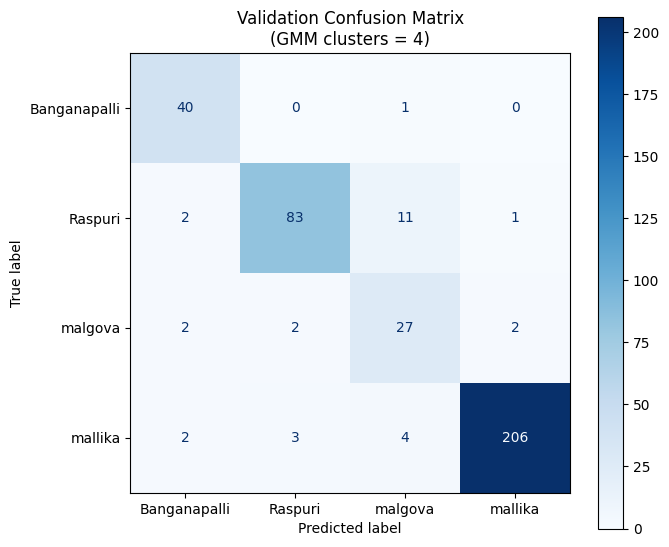

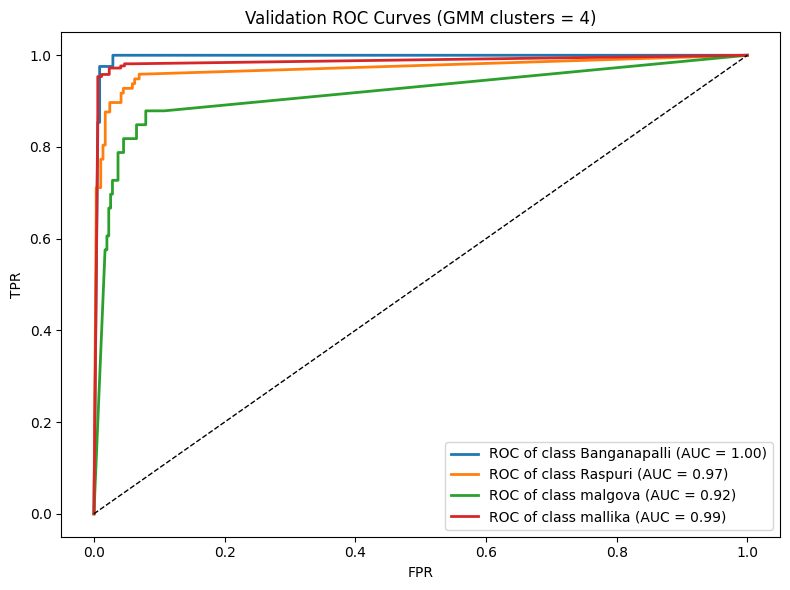

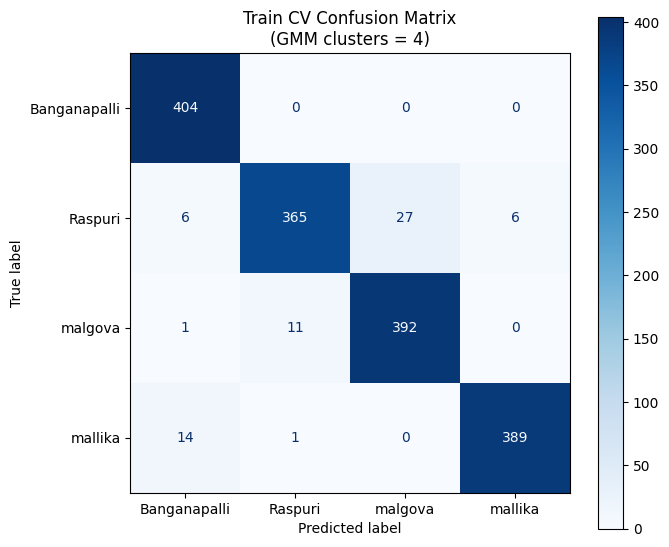

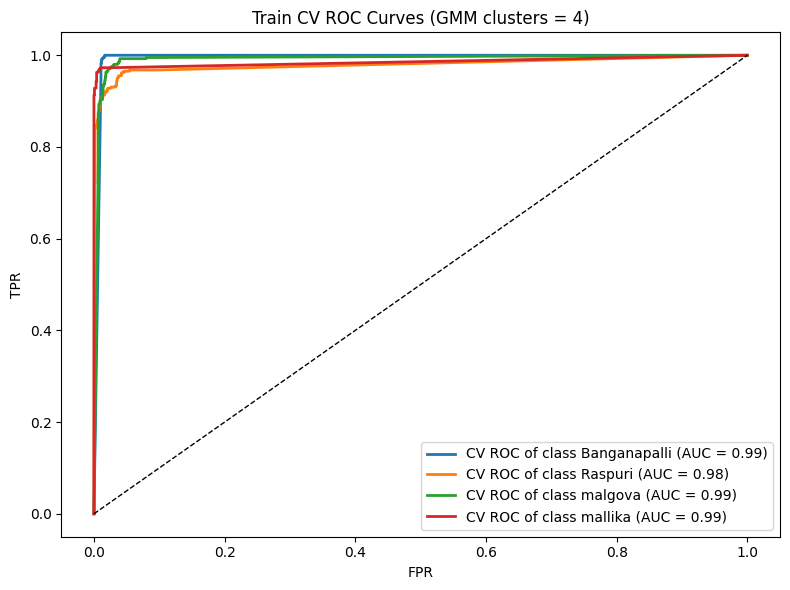

Model saved to /Users/ranjanumeshrao/Downloads/DAL_Lab/Mango/5CLASS_CLUSTERING/Guassian_Mixture_Model/gmm_knn_model_final.joblib
Metadata saved to /Users/ranjanumeshrao/Downloads/DAL_Lab/Mango/5CLASS_CLUSTERING/Guassian_Mixture_Model/gmm_knn_metadata_final.joblib

Performing inference on validation data...
Inference Accuracy: 0.9223


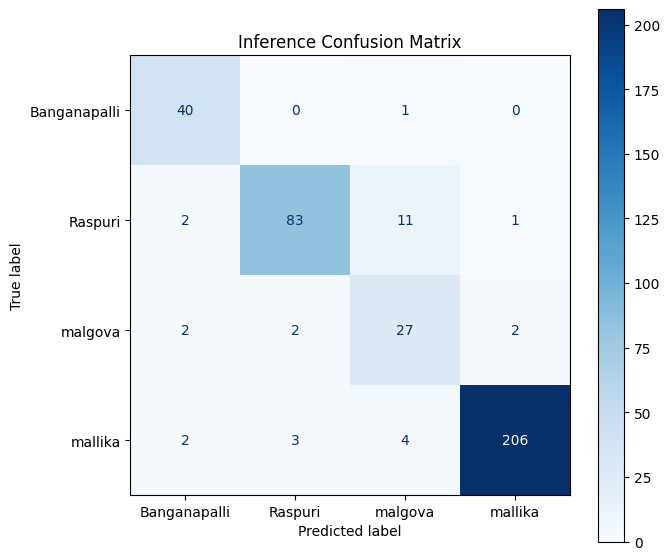

In [10]:
import pandas as pd
import numpy as np
import os
import joblib
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, cross_val_predict, cross_val_score
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_curve,
    auc
)
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

# --- PARAMETERS ---
train_csv           = '/Users/ranjanumeshrao/Downloads/DAL_Lab/Mango/5CLASS_CLUSTERING/data/FE_data/train_balanced_dataset.csv'
val_csv             = '/Users/ranjanumeshrao/Downloads/DAL_Lab/Mango/5CLASS_CLUSTERING/data/FE_data/val_no_outliers.csv'
target_col          = 'target'
drop_cols           = []
remove_classes      = ['Badami']
n_clusters          = 4
random_state        = 42
cv_folds            = 5
max_features        = 19
model_save_path     = '/Users/ranjanumeshrao/Downloads/DAL_Lab/Mango/5CLASS_CLUSTERING/Guassian_Mixture_Model/gmm_knn_model_final.joblib'
metadata_save_path  = '/Users/ranjanumeshrao/Downloads/DAL_Lab/Mango/5CLASS_CLUSTERING/Guassian_Mixture_Model/gmm_knn_metadata_final.joblib'

# --- DATA LOADING & FILTERING ---
def load_and_filter(path):
    df = pd.read_csv(path).drop(columns=drop_cols)
    if remove_classes:
        df = df[~df[target_col].isin(remove_classes)]
    return df

df_train = load_and_filter(train_csv)
df_val   = load_and_filter(val_csv)

X_train = df_train.drop(columns=[target_col])
y_train = df_train[target_col]

X_val   = df_val.drop(columns=[target_col, 'image_name'])
y_val   = df_val[target_col]

# --- SCALER: fit on TRAIN, apply to both ---
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_val_scaled   = scaler.transform(X_val)

# --- GMM: fit on TRAIN, predict clusters for both ---
gmm = GaussianMixture(
    n_components=n_clusters,
    covariance_type='full',
    random_state=random_state
)
gmm.fit(X_train_scaled)

train_clusters = gmm.predict(X_train_scaled)
val_clusters   = gmm.predict(X_val_scaled)

# Append cluster-label as new column
X_train_aug = np.hstack([X_train_scaled, train_clusters.reshape(-1,1)])
X_val_aug   = np.hstack([X_val_scaled,   val_clusters.reshape(-1,1)])

# Build column names
orig_cols = X_train.columns.tolist()
all_cols  = orig_cols + ['cluster_label']

X_train_df = pd.DataFrame(X_train_aug, columns=all_cols)
X_val_df   = pd.DataFrame(X_val_aug,   columns=all_cols)

# --- FEATURE SELECTION on TRAIN only ---
knn_base = KNeighborsClassifier()
sfs = SFS(
    estimator=knn_base,
    k_features=(1, max_features),
    forward=True,
    floating=False,
    scoring='accuracy',
    cv=cv_folds,
    n_jobs=-1
)
sfs = sfs.fit(X_train_df, y_train)

selected_idx   = list(sfs.k_feature_idx_)
selected_feats = [all_cols[i] for i in selected_idx]

print("Selected features:", selected_feats)
print(len(selected_feats))
print(f"SFS CV score: {sfs.k_score_:.4f}")

X_train_sel = X_train_df[selected_feats]
X_val_sel   = X_val_df[selected_feats]

# --- GRID SEARCH for KNN on TRAIN ---
param_grid = {
    'n_neighbors': [4, 5, 7, 10],
    'weights':     ['uniform', 'distance'],
    'p':           [1, 2]
}

grid = GridSearchCV(
    KNeighborsClassifier(),
    param_grid,
    cv=cv_folds,
    scoring='accuracy',
    n_jobs=-1
)
grid.fit(X_train_sel, y_train)

print("Best KNN params:", grid.best_params_)
print(f"Best TRAIN CV accuracy: {grid.best_score_:.4f}")

knn_final = grid.best_estimator_

# ======================================================
# <<< ADDED HERE >>> 1) Validation CV accuracy
# ======================================================
val_cv_scores = cross_val_score(
    knn_final,
    X_val_sel, y_val,
    cv=cv_folds,
    scoring='accuracy',
    n_jobs=-1
)
print(f"Validation {cv_folds}-fold CV accuracy: {val_cv_scores.mean():.4f} ± {val_cv_scores.std():.4f}")

# ======================================================
# 2) Validation set metrics: CM + ROC
# ======================================================
y_val_pred  = knn_final.predict(X_val_sel)
y_val_proba = knn_final.predict_proba(X_val_sel)
val_acc     = accuracy_score(y_val, y_val_pred)
print(f"Validation hold‑out accuracy: {val_acc:.4f}")

# CM
classes   = knn_final.classes_
cm_val    = confusion_matrix(y_val, y_val_pred, labels=classes)
disp_val  = ConfusionMatrixDisplay(cm_val, display_labels=classes)
fig, ax   = plt.subplots(figsize=(7, 6))
disp_val.plot(ax=ax, cmap=plt.cm.Blues)
ax.set_title(f'Validation Confusion Matrix\n(GMM clusters = {n_clusters})')
plt.tight_layout()
plt.savefig('val_confusion_matrix_gmm_knn.png')
plt.show()

# ROC‑AUC
y_val_bin = label_binarize(y_val, classes=classes)
fpr_val, tpr_val, roc_auc_val = {}, {}, {}
for i, cls in enumerate(classes):
    fpr_val[i], tpr_val[i], _ = roc_curve(y_val_bin[:, i], y_val_proba[:, i])
    roc_auc_val[i] = auc(fpr_val[i], tpr_val[i])

plt.figure(figsize=(8, 6))
for i, cls in enumerate(classes):
    plt.plot(fpr_val[i], tpr_val[i],
             lw=2,
             label=f'ROC of class {cls} (AUC = {roc_auc_val[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title(f'Validation ROC Curves (GMM clusters = {n_clusters})')
plt.legend(loc="lower right")
plt.tight_layout()
plt.savefig('val_roc_gmm_knn.png')
plt.show()


# ======================================================
# 3) Train‑CV metrics: CM + ROC (out‑of‑fold)
# ======================================================
# Obtain out‑of‑fold probabilities & predictions
y_train_oof_proba = cross_val_predict(
    knn_final,
    X_train_sel, y_train,
    cv=cv_folds,
    method='predict_proba',
    n_jobs=-1
)
y_train_oof_pred = knn_final.classes_[np.argmax(y_train_oof_proba, axis=1)]

# Train‑CV confusion matrix
cm_cv = confusion_matrix(y_train, y_train_oof_pred, labels=classes)
disp_cv = ConfusionMatrixDisplay(cm_cv, display_labels=classes)
fig, ax = plt.subplots(figsize=(7, 6))
disp_cv.plot(ax=ax, cmap=plt.cm.Blues)
ax.set_title(f'Train CV Confusion Matrix\n(GMM clusters = {n_clusters})')
plt.tight_layout()
plt.savefig('train_cv_confusion_matrix_gmm_knn.png')
plt.show()

# Train‑CV ROC‑AUC
y_train_oof_bin = label_binarize(y_train, classes=classes)
fpr_cv, tpr_cv, roc_auc_cv = {}, {}, {}
for i, cls in enumerate(classes):
    fpr_cv[i], tpr_cv[i], _ = roc_curve(y_train_oof_bin[:, i], y_train_oof_proba[:, i])
    roc_auc_cv[i] = auc(fpr_cv[i], tpr_cv[i])

plt.figure(figsize=(8, 6))
for i, cls in enumerate(classes):
    plt.plot(fpr_cv[i], tpr_cv[i],
             lw=2,
             label=f'CV ROC of class {cls} (AUC = {roc_auc_cv[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title(f'Train CV ROC Curves (GMM clusters = {n_clusters})')
plt.legend(loc="lower right")
plt.tight_layout()
plt.savefig('train_cv_roc_gmm_knn.png')
plt.show()


# --- SAVE THE MODEL AND METADATA (unchanged) ---
model_components = {
    'scaler': scaler,
    'gmm': gmm,
    'knn': knn_final
}
metadata = {
    'orig_cols':     orig_cols,
    'all_cols':      all_cols,
    'selected_feats': selected_feats
}
os.makedirs(os.path.dirname(model_save_path), exist_ok=True)
joblib.dump(model_components, model_save_path)
joblib.dump(metadata, metadata_save_path)
print(f"Model saved to {model_save_path}")
print(f"Metadata saved to {metadata_save_path}")


# --- INFERENCE FUNCTION (unchanged) ---
def perform_inference(X, y=None, model_path=model_save_path, metadata_path=metadata_save_path):
    model_components = joblib.load(model_path)
    metadata = joblib.load(metadata_path)

    scaler = model_components['scaler']
    gmm    = model_components['gmm']
    knn    = model_components['knn']
    orig_cols      = metadata['orig_cols']
    all_cols       = metadata['all_cols']
    selected_feats = metadata['selected_feats']

    X_scaled = scaler.transform(X)
    clusters = gmm.predict(X_scaled)

    X_aug = np.hstack([X_scaled, clusters.reshape(-1, 1)])
    X_df  = pd.DataFrame(X_aug, columns=all_cols)
    X_sel = X_df[selected_feats]

    y_pred = knn.predict(X_sel)

    if y is not None:
        acc = accuracy_score(y, y_pred)
        print(f"Inference Accuracy: {acc:.4f}")

        cm = confusion_matrix(y, y_pred, labels=knn.classes_)
        disp = ConfusionMatrixDisplay(cm, display_labels=knn.classes_)
        fig, ax = plt.subplots(figsize=(7, 6))
        disp.plot(ax=ax, cmap=plt.cm.Blues)
        ax.set_title('Inference Confusion Matrix')
        plt.tight_layout()
        plt.savefig('inference_confusion_matrix.png')
        plt.show()

    return y_pred

# --- PERFORM INFERENCE ON VALIDATION DATA (unchanged) ---
print("\nPerforming inference on validation data...")
y_val_pred_inference = perform_inference(X_val, y_val)

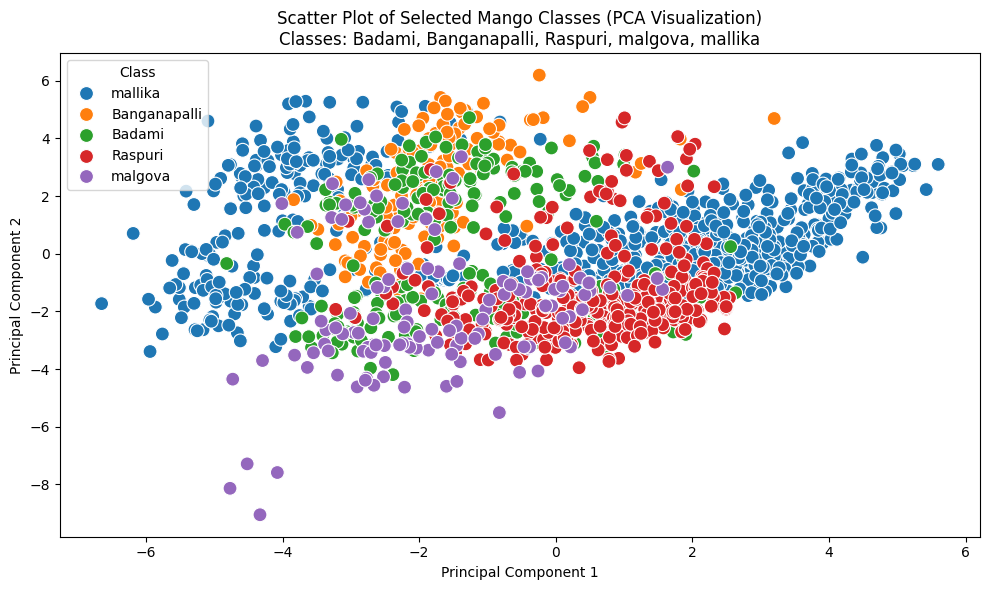

In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

def plot_selected_classes_scatter(train_csv_path, selected_classes=None):
    # Load the training CSV file
    train_df = pd.read_csv(train_csv_path)

    # Identify feature columns (exclude 'img_name' and 'target')
    feature_columns = [col for col in train_df.columns if col not in ['image_name', 'target']]

    # Filter the DataFrame to include only the selected classes (if specified)
    if selected_classes is not None:
        train_df = train_df[train_df['target'].isin(selected_classes)]
        if train_df.empty:
            print(f"No data found for the selected classes: {selected_classes}")
            return

    # Extract features and true labels
    X = train_df[feature_columns].values
    true_labels = train_df['target'].values

    # Standardize the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Reduce dimensionality to 2D using PCA
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)

    # Create a DataFrame for visualization
    visual_df = pd.DataFrame({
        'PC1': X_pca[:, 0],
        'PC2': X_pca[:, 1],
        'True Label': true_labels
    })

    # Plot the scatter plot
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=visual_df, x='PC1', y='PC2', hue='True Label', s=100)
    plt.title(f'Scatter Plot of Selected Mango Classes (PCA Visualization)\nClasses: {", ".join(sorted(set(true_labels)))}')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend(title='Class')
    plt.tight_layout()
    plt.savefig('selected_classes_scatter_pca.png')
    plt.show()

if __name__ == "__main__":
    # Define the path to your CSV file
    train_csv_path = '/Users/ranjanumeshrao/Downloads/DAL_Lab/Mango/5CLASS_CLUSTERING/data/FE_data/train_no_outliers.csv'

    
    selected_classes = ['mallika', 'Banganapalli','Raspuri','malgova','Badami']

    # Generate the scatter plot
    plot_selected_classes_scatter(train_csv_path, selected_classes)

In [1]:
from google.colab import drive
drive.mount('/content/MyDrive')

Mounted at /content/MyDrive


Selected features: ['edge_density', 'edge_intensity_std', 'HSV_H_mean', 'HSV_H_std', 'HSV_S_mean', 'HSV_S_std', 'HSV_V_mean', 'HSV_V_std', 'LAB_L_mean', 'LAB_A_mean', 'LAB_B_mean', 'LAB_B_std', 'area', 'perimeter', 'aspect_ratio', 'cluster_label']
SFS CV score: 0.8465
Best KNN params: {'n_neighbors': 5, 'p': 1, 'weights': 'distance'}
Best TRAIN CV accuracy: 0.8772
Validation accuracy: 0.8022


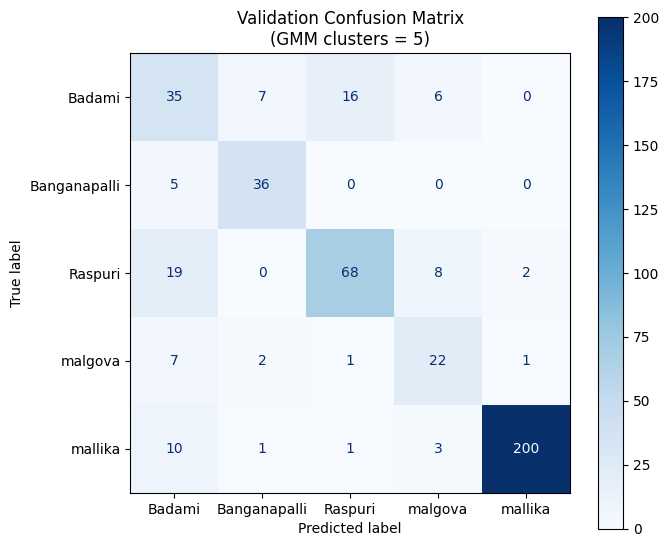

Model saved to /content/MyDrive/MyDrive/Feature_extaction/GMM/gmm_knn_model_5class.joblib
Metadata saved to /content/MyDrive/MyDrive/Feature_extaction/GMM/gmm_knn_metadata_5class.joblib

Performing inference on validation data...
Inference Accuracy: 0.8022


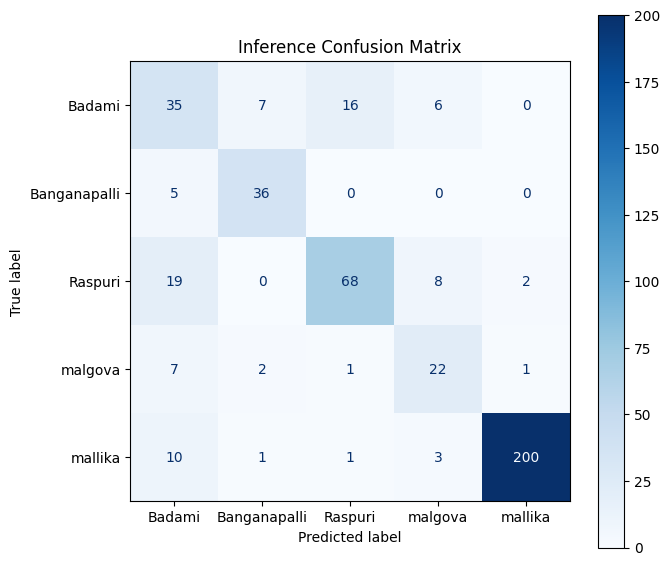

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
import matplotlib.pyplot as plt
import joblib
import os

# --- PARAMETERS ---
train_csv       = '/content/MyDrive/MyDrive/Feature_extaction/FE_data/balanced_dataset.csv'
val_csv         = '/content/MyDrive/MyDrive/Feature_extaction/val_no_outliers.csv'
target_col      = 'target'
drop_cols       = []                # any cols to drop up front
remove_classes  = []        # classes to remove entirely
n_clusters      = 5                # desired GMM components
random_state    = 42
cv_folds        = 5
max_features    = 19               # upper bound for SFS
model_save_path = '/content/MyDrive/MyDrive/Feature_extaction/GMM/gmm_knn_model_5class.joblib'
metadata_save_path = '/content/MyDrive/MyDrive/Feature_extaction/GMM/gmm_knn_metadata_5class.joblib'

# --- DATA LOADING & FILTERING ---
def load_and_filter(path):
    df = pd.read_csv(path).drop(columns=drop_cols)
    if remove_classes:
        df = df[~df[target_col].isin(remove_classes)]
    return df

df_train = load_and_filter(train_csv)
df_val   = load_and_filter(val_csv)

X_train = df_train.drop(columns=[target_col])
y_train = df_train[target_col]

X_val   = df_val.drop(columns=['target', 'image_name'])
y_val   = df_val[target_col]

# --- SCALER: fit on TRAIN, apply to both ---
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_val_scaled   = scaler.transform(X_val)

# --- GMM: fit on TRAIN, predict labels for both ---
gmm = GaussianMixture(n_components=n_clusters,
                      covariance_type='full',
                      random_state=random_state)
gmm.fit(X_train_scaled)

train_clusters = gmm.predict(X_train_scaled)
val_clusters   = gmm.predict(X_val_scaled)

# Append cluster-label as new column
X_train_aug = np.hstack([X_train_scaled, train_clusters.reshape(-1,1)])
X_val_aug   = np.hstack([X_val_scaled,   val_clusters.reshape(-1,1)])

# Build column names
orig_cols = X_train.columns.tolist()
all_cols  = orig_cols + ['cluster_label']

X_train_df = pd.DataFrame(X_train_aug, columns=all_cols)
X_val_df   = pd.DataFrame(X_val_aug,   columns=all_cols)

# --- FEATURE SELECTION on TRAIN only ---
knn_base = KNeighborsClassifier()
sfs = SFS(estimator=knn_base,
          k_features=(1, max_features),
          forward=True,
          floating=False,
          scoring='accuracy',
          cv=cv_folds,
          n_jobs=-1)

sfs = sfs.fit(X_train_df, y_train)
selected_idx   = list(sfs.k_feature_idx_)
selected_feats = [all_cols[i] for i in selected_idx]

print("Selected features:", selected_feats)
print(f"SFS CV score: {sfs.k_score_:.4f}")

# Subselect columns
X_train_sel = X_train_df[selected_feats]
X_val_sel   = X_val_df[selected_feats]

# --- GRID SEARCH for KNN on TRAIN ---
param_grid = {
    'n_neighbors': [4, 5, 7, 10],
    'weights':     ['uniform', 'distance'],
    'p':           [1, 2]
}

grid = GridSearchCV(KNeighborsClassifier(),
                    param_grid,
                    cv=cv_folds,
                    scoring='accuracy',
                    n_jobs=-1)
grid.fit(X_train_sel, y_train)

print("Best KNN params:", grid.best_params_)
print(f"Best TRAIN CV accuracy: {grid.best_score_:.4f}")

# --- FINAL EVALUATION on VALIDATION SET ---
knn_final = grid.best_estimator_
y_val_pred = knn_final.predict(X_val_sel)
val_acc = accuracy_score(y_val, y_val_pred)
print(f"Validation accuracy: {val_acc:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_val, y_val_pred, labels=knn_final.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=knn_final.classes_)

fig, ax = plt.subplots(figsize=(7, 6))
disp.plot(ax=ax, cmap=plt.cm.Blues)
ax.set_title(f'Validation Confusion Matrix\n(GMM clusters = {n_clusters})')
plt.tight_layout()
plt.savefig('confusion_matrix_gmm_knn.png')
plt.show()

# --- SAVE THE MODEL AND METADATA ---
# Create a dictionary for the model components
model_components = {
    'scaler': scaler,
    'gmm': gmm,
    'knn': knn_final
}

# Save metadata (selected features, original columns, etc.)
metadata = {
    'orig_cols': orig_cols,
    'all_cols': all_cols,
    'selected_feats': selected_feats
}

# Ensure the save directory exists
os.makedirs(os.path.dirname(model_save_path), exist_ok=True)

# Save the model components and metadata
joblib.dump(model_components, model_save_path)
joblib.dump(metadata, metadata_save_path)
print(f"Model saved to {model_save_path}")
print(f"Metadata saved to {metadata_save_path}")

# --- INFERENCE FUNCTION ---
def perform_inference(X, y=None, model_path=model_save_path, metadata_path=metadata_save_path):
    # Load the model and metadata
    model_components = joblib.load(model_path)
    metadata = joblib.load(metadata_path)

    # Extract components
    scaler = model_components['scaler']
    gmm = model_components['gmm']
    knn = model_components['knn']
    orig_cols = metadata['orig_cols']
    all_cols = metadata['all_cols']
    selected_feats = metadata['selected_feats']

    # Standardize the features
    X_scaled = scaler.transform(X)

    # Predict clusters using GMM
    clusters = gmm.predict(X_scaled)

    # Append cluster labels
    X_aug = np.hstack([X_scaled, clusters.reshape(-1, 1)])
    X_df = pd.DataFrame(X_aug, columns=all_cols)

    # Select the features used during training
    X_selected = X_df[selected_feats]

    # Predict using KNN
    y_pred = knn.predict(X_selected)

    # If true labels are available, calculate accuracy
    if y is not None:
        acc = accuracy_score(y, y_pred)
        print(f"Inference Accuracy: {acc:.4f}")

        # Generate confusion matrix
        cm = confusion_matrix(y, y_pred, labels=knn.classes_)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=knn.classes_)
        fig, ax = plt.subplots(figsize=(7, 6))
        disp.plot(ax=ax, cmap=plt.cm.Blues)
        ax.set_title('Inference Confusion Matrix')
        plt.tight_layout()
        plt.savefig('inference_confusion_matrix.png')
        plt.show()

    return y_pred

# --- PERFORM INFERENCE ON VALIDATION DATA ---
print("\nPerforming inference on validation data...")
y_val_pred_inference = perform_inference(X_val, y_val)

# running it on unbalanced original data

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, cross_val_predict, GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
import matplotlib.pyplot as plt
import numpy as np

# --- PARAMETERS ---
csv_path       = '/content/MyDrive/MyDrive/Feature_extaction/train_no_outliers.csv'
target_col     = 'target'
drop_cols      = ['image_name']
remove_classes = []
cv_folds       = 5
max_features   = 19

# --- LOAD DATA ---
df = pd.read_csv(csv_path).drop(columns=drop_cols)

# --- REMOVE SPECIFIED CLASSES ---
if remove_classes:
    before = df.shape[0]
    df = df[~df[target_col].isin(remove_classes)]
    after = df.shape[0]
    print(f"Dropped {before - after} rows with target in {remove_classes}. New dataset size: {df.shape}")

# --- SPLIT FEATURES / TARGET ---
X = df.drop(columns=[target_col])
y = df[target_col]

# --- PREPROCESS WITH CLUSTERING ---
def apply_clustering(X, method='kmeans', n_clusters=4, random_state=42):
    if method == 'kmeans':
        clusterer = KMeans(n_clusters=n_clusters, random_state=random_state)
    elif method == 'gmm':
        clusterer = GaussianMixture(n_components=n_clusters, random_state=random_state)
    else:
        raise ValueError("Method must be 'kmeans' or 'gmm'")
    cluster_labels = clusterer.fit_predict(X)
    # Convert cluster labels to one-hot encoded features
    cluster_features = np.zeros((X.shape[0], n_clusters))
    cluster_features[np.arange(X.shape[0]), cluster_labels] = 1
    # Combine original features with cluster features
    X_processed = np.hstack((X.values, cluster_features))
    # Define column names for the new DataFrame
    orig_cols = X.columns.tolist()
    cluster_cols = [f'cluster_{i}' for i in range(n_clusters)]
    all_cols = orig_cols + cluster_cols
    return pd.DataFrame(X_processed, columns=all_cols)

X_kmeans = apply_clustering(X, method='kmeans', n_clusters=4)
X_gmm = apply_clustering(X, method='gmm', n_clusters=4)

# --- DEFINE PIPELINES ---
pipe_kmeans = Pipeline([
    ("scaler", StandardScaler()),
    ("knn", KNeighborsClassifier())
])

pipe_gmm = Pipeline([
    ("scaler", StandardScaler()),
    ("knn", KNeighborsClassifier())
])

# --- PARAMETER GRIDS FOR TUNING ---
param_grid_kmeans = {
    'knn__n_neighbors': [4, 5, 7, 10],
    'knn__weights': ['uniform', 'distance']
}

param_grid_gmm = {
    'knn__n_neighbors': [4, 5, 7, 10],
    'knn__weights': ['uniform', 'distance']
}

# --- FEATURE SELECTION WITH SFS ---
def run_sfs(pipeline, param_grid, X, y):
    sfs = SFS(
        estimator=pipeline,
        k_features=(1, max_features),
        forward=True,
        floating=False,
        scoring='accuracy',
        cv=cv_folds,
        n_jobs=-1
    )
    sfs = sfs.fit(X, y)
    best_idx = list(sfs.k_feature_idx_)
    best_feats = [X.columns[i] for i in best_idx]
    return best_feats, sfs.k_score_

# --- GRID SEARCH FUNCTION ---
def run_grid_search(pipeline, param_grid, X, y):
    grid_search = GridSearchCV(pipeline, param_grid, cv=cv_folds, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X, y)
    return grid_search.best_params_, grid_search.best_score_

# --- RUN EXPERIMENTS ---
clustering_methods = [
    ("K-means", X_kmeans, pipe_kmeans, param_grid_kmeans),
    ("GMM", X_gmm, pipe_gmm, param_grid_gmm)
]

for name, X_processed, pipeline, param_grid in clustering_methods:
    print(f"\n--- Experimenting with {name} ---")

    # Feature Selection
    best_feats, sfs_score = run_sfs(pipeline, param_grid, X_processed, y)
    X_best = X_processed[best_feats]
    print(f"Best features for {name}: {best_feats}")
    print(f"SFS CV accuracy: {sfs_score:.4f}")

    # Hyperparameter Tuning
    best_params, best_score = run_grid_search(pipeline, param_grid, X_best, y)
    print(f"Best parameters for {name}: {best_params}")
    print(f"Best CV accuracy for {name}: {best_score:.4f}")

    # Fit pipeline with best parameters and generate confusion matrix
    pipeline.set_params(**best_params)
    pipeline.fit(X_best, y)
    y_pred = cross_val_predict(pipeline, X_best, y, cv=cv_folds, n_jobs=-1)

    # Confusion Matrix
    cm = confusion_matrix(y, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipeline.named_steps['knn'].classes_)

    fig, ax = plt.subplots(figsize=(8, 6))
    disp.plot(ax=ax, cmap=plt.cm.Blues)
    ax.set_title(f'Confusion Matrix for {name} (CV={cv_folds})')
    plt.tight_layout()
    plt.savefig(f'confusion_matrix_{name.lower()}.png')
    plt.close()


--- Experimenting with K-means ---
Best features for K-means: ['edge_density', 'HSV_H_mean', 'HSV_S_mean', 'HSV_S_std', 'HSV_V_mean', 'HSV_V_std', 'LAB_L_std', 'LAB_A_mean', 'LAB_B_mean', 'LAB_B_std', 'area', 'perimeter']
SFS CV accuracy: 0.8573
Best parameters for K-means: {'knn__n_neighbors': 5, 'knn__weights': 'distance'}
Best CV accuracy for K-means: 0.8630

--- Experimenting with GMM ---
Best features for GMM: ['edge_density', 'HSV_H_mean', 'HSV_S_mean', 'HSV_S_std', 'HSV_V_mean', 'HSV_V_std', 'LAB_L_std', 'LAB_A_mean', 'LAB_B_mean', 'LAB_B_std', 'area', 'perimeter', 'cluster_0', 'cluster_2']
SFS CV accuracy: 0.8584
Best parameters for GMM: {'knn__n_neighbors': 5, 'knn__weights': 'distance'}
Best CV accuracy for GMM: 0.8635


# Kmeans + KNN

Selected features: ['edge_density', 'HSV_S_mean', 'HSV_S_std', 'HSV_V_std', 'LAB_L_mean', 'LAB_A_mean', 'LAB_B_std', 'area']
Train Accuracy: 0.8571
Test Accuracy: 0.8249


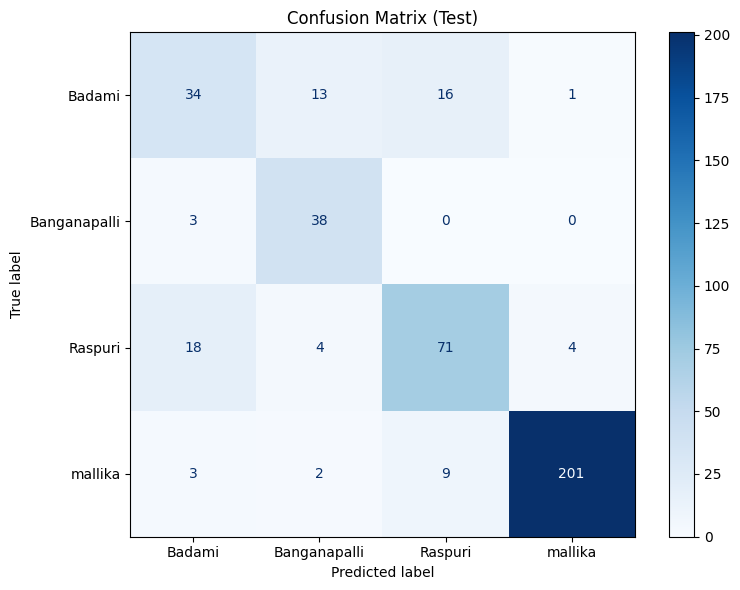

ROC AUC plot skipped (not binary classification).


In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import joblib
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_auc_score,
    roc_curve,
    accuracy_score
)
from sklearn.model_selection import cross_val_score
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

# --- PARAMETERS ---
train_csv_path = '/Users/ranjanumeshrao/Downloads/DAL_Lab/Mango/5CLASS_CLUSTERING/data/FE_data/train_balanced_dataset.csv'
test_csv_path  = '/Users/ranjanumeshrao/Downloads/DAL_Lab/Mango/5CLASS_CLUSTERING/data/FE_data/val_no_outliers.csv'
target_col     = 'target'
drop_cols      = ['image_name']
remove_classes = ['malgova']
n_clusters     = 4
k_neighbors    = 5
cv_folds       = 5
max_features   = 19

# --- LOAD AND FILTER TRAIN DATA ---
train_df = pd.read_csv(train_csv_path).drop(columns=drop_cols, errors='ignore')
if remove_classes:
    train_df = train_df[~train_df[target_col].isin(remove_classes)]

X_train = train_df.drop(columns=[target_col])
y_train = train_df[target_col]

# --- BUILD PIPELINE ---
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("kmeans", KMeans(n_clusters=n_clusters, random_state=42)),
    ("knn",    KNeighborsClassifier(n_neighbors=k_neighbors))
])

# --- FEATURE SELECTION ---
sfs = SFS(
    estimator=pipe,
    k_features=(1, max_features),
    forward=True,
    floating=False,
    scoring='accuracy',
    cv=cv_folds,
    n_jobs=-1
)
sfs.fit(X_train, y_train)

# --- SELECT BEST FEATURES ---
best_idx   = list(sfs.k_feature_idx_)
best_feats = [X_train.columns[i] for i in best_idx]
print(f"Selected features: {best_feats}")

# --- FIT PIPELINE ON BEST FEATURES ---
X_train_best = X_train[best_feats]
pipe.fit(X_train_best, y_train)

# --- SAVE MODEL AND FEATURES ---
joblib.dump(pipe, 'trained_model.pkl')
joblib.dump(best_feats, 'selected_features.pkl')

# --- EVALUATE ON TRAIN ---
y_train_pred = pipe.predict(X_train_best)
train_acc = accuracy_score(y_train, y_train_pred)
print(f"Train Accuracy: {train_acc:.4f}")

# --- LOAD AND FILTER TEST DATA ---
test_df = pd.read_csv(test_csv_path).drop(columns=drop_cols, errors='ignore')
if remove_classes:
    test_df = test_df[~test_df[target_col].isin(remove_classes)]

X_test = test_df.drop(columns=[target_col])
y_test = test_df[target_col]

# --- LOAD SAVED MODEL ---
loaded_pipe = joblib.load('trained_model.pkl')
selected_features = joblib.load('selected_features.pkl')

# --- EVALUATE ON TEST ---
X_test_best = X_test[selected_features]
y_test_pred = loaded_pipe.predict(X_test_best)
test_acc = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy: {test_acc:.4f}")

# --- CONFUSION MATRIX ---
cm = confusion_matrix(y_test, y_test_pred, labels=np.unique(y_test))
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=np.unique(y_test))

fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax, cmap=plt.cm.Blues)
ax.set_title(f'Confusion Matrix (Test)')
plt.tight_layout()
plt.show()

# --- ROC AUC (for binary classification only) ---
if len(np.unique(y_test)) == 2:
    y_test_prob = loaded_pipe.predict_proba(X_test_best)[:, 1]
    auc = roc_auc_score(y_test, y_test_prob)
    fpr, tpr, _ = roc_curve(y_test, y_test_prob)
    plt.figure()
    plt.plot(fpr, tpr, label=f'ROC AUC = {auc:.2f}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC AUC Curve (Test)')
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("ROC AUC plot skipped (not binary classification).")

## Final Testing

Filtered and balanced data overview

In [3]:
# training Dataset
import pandas as pd
df = pd.read_csv('data/FE_data/Train-test/train_balanced_dataset.csv')
df['target'].value_counts()

target
Badami          404
Banganapalli    404
Raspuri         404
malgova         404
mallika         404
Name: count, dtype: int64

In [4]:
# test dataset
import pandas as pd
df = pd.read_csv('data/FE_data/Train-test/val_no_outliers.csv')
df['target'].value_counts()

target
mallika         215
Raspuri          97
Badami           64
Banganapalli     41
malgova          33
Name: count, dtype: int64

K-Means And GMM clustering + 5 different classifiers

In [6]:
df = pd.read_csv('data/FE_data/Train-test/train_balanced_dataset.csv')
len(df.columns)

20

K-means , GMM 5classifiers

In [3]:
import os
import json
import joblib
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from itertools import cycle
from sklearn.preprocessing    import StandardScaler, label_binarize
from sklearn.cluster          import KMeans
from sklearn.mixture          import GaussianMixture
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.linear_model     import LogisticRegression
from sklearn.tree             import DecisionTreeClassifier
from sklearn.neighbors        import KNeighborsClassifier
from sklearn.base             import BaseEstimator, ClassifierMixin
from sklearn.model_selection  import StratifiedKFold, GridSearchCV
from sklearn.metrics          import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
    average_precision_score,
    confusion_matrix, ConfusionMatrixDisplay,
    roc_curve, auc,
    precision_recall_curve
)

warnings.filterwarnings("ignore", category=UserWarning)

# ───────────────────────────────────────────────────────────────────────────────
# Configuration
# ───────────────────────────────────────────────────────────────────────────────
TRAIN_CSV        = "data/FE_data/Train-test/train_balanced_dataset.csv"
TEST_CSV         = "data/FE_data/Train-test/val_no_outliers.csv"
TARGET           = "target"
EXCLUDE_CLASSES  = ["Badami"]
NON_FEATURES     = ["image_name"]
RAND             = 42
K_CLUSTERS       = 4
CV_FOLDS         = 5
SFS_MAX_FEATS    = 20
SAVE_DIR         = "saved_pipeline"

os.makedirs(SAVE_DIR, exist_ok=True)


# ───────────────────────────────────────────────────────────────────────────────
# Custom GMMClassifier
# ───────────────────────────────────────────────────────────────────────────────
class GMMClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, n_components=1, covariance_type="full", random_state=None):
        self.n_components = n_components
        self.covariance_type = covariance_type
        self.random_state = random_state
    
    def fit(self, X, y):
        if hasattr(X, 'values'):
            X = X.values
        if hasattr(y, 'values'):
            y = y.values

        self.classes_, _ = np.unique(y, return_inverse=True)
        self.models_, self.priors_ = [], []

        for cls in self.classes_:
            mask = (y == cls)
            X_cls = X[mask]
            gmm = GaussianMixture(
                n_components=self.n_components,
                covariance_type=self.covariance_type,
                random_state=self.random_state
            ).fit(X_cls)
            self.models_.append(gmm)
            self.priors_.append(mask.mean())

        self.priors_ = np.array(self.priors_)
        return self
    
    def _joint_ll(self, X):
        if hasattr(X, 'values'):
            X = X.values
        return np.column_stack([
            mdl.score_samples(X) + np.log(p)
            for mdl, p in zip(self.models_, self.priors_)
        ])
    
    def predict_proba(self, X):
        ll = self._joint_ll(X)
        ll -= ll.max(1, keepdims=True)
        post = np.exp(ll)
        return post / post.sum(1, keepdims=True)
    
    def predict(self, X):
        ll = self._joint_ll(X)
        return self.classes_[np.argmax(ll, axis=1)]


# ───────────────────────────────────────────────────────────────────────────────
# Data loading helper
# ───────────────────────────────────────────────────────────────────────────────
def load_frame(path):
    df = pd.read_csv(path)
    if EXCLUDE_CLASSES:
        df = df[~df[TARGET].isin(EXCLUDE_CLASSES)]
    return df


train_df = load_frame(TRAIN_CSV)
test_df  = load_frame(TEST_CSV)

X_train = train_df.drop(columns=[TARGET])
y_train = train_df[TARGET]

X_test = test_df.drop(columns=[TARGET] + [
    c for c in NON_FEATURES if c in test_df
], errors="ignore")
y_test = test_df[TARGET]


# ───────────────────────────────────────────────────────────────────────────────
# Plotting utilities
# ───────────────────────────────────────────────────────────────────────────────
classes = np.unique(y_train)

def plot_conf(y_true, y_pred, title, fn):
    cm = confusion_matrix(y_true, y_pred, labels=classes)
    fig, ax = plt.subplots(figsize=(6,5))
    ConfusionMatrixDisplay(cm, display_labels=classes).plot(ax=ax, cmap=plt.cm.Blues)
    ax.set_title(title)
    plt.tight_layout()
    plt.savefig(fn)
    plt.close()

def plot_curves(y_true_bin, prob, title, pref):
    # ROC curves
    plt.figure(figsize=(7,6))
    for i, cls in enumerate(classes):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], prob[:, i])
        plt.plot(fpr, tpr, lw=2, label=f"{cls} (AUC={auc(fpr, tpr):.2f})")
    plt.plot([0,1],[0,1], 'k--')
    plt.title(f"{title} – ROC")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"{pref}_roc.png")
    plt.close()

    # Precision-Recall curves
    plt.figure(figsize=(7,6))
    for i, cls in enumerate(classes):
        pr, re, _ = precision_recall_curve(y_true_bin[:, i], prob[:, i])
        plt.plot(re, pr, lw=2, label=f"{cls} (AUC={auc(re, pr):.2f})")
    plt.title(f"{title} – PR")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"{pref}_pr.png")
    plt.close()

    # F1 vs Threshold
    plt.figure(figsize=(7,6))
    for i, (cls, col) in enumerate(zip(classes, cycle(plt.cm.tab10.colors))):
        pr, re, th = precision_recall_curve(y_true_bin[:, i], prob[:, i])
        f1 = 2 * pr * re / (pr + re + 1e-12)
        plt.plot(th, f1[:-1], lw=2, label=cls, color=col)
    plt.title(f"{title} – F1 vs Threshold")
    plt.xlabel("Threshold")
    plt.ylabel("F1-score")
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"{pref}_f1.png")
    plt.close()


# ───────────────────────────────────────────────────────────────────────────────
# Base models & grids
# ───────────────────────────────────────────────────────────────────────────────
base_models = {
    "LR" : LogisticRegression(max_iter=5000, solver="lbfgs"),
    "DT" : DecisionTreeClassifier(random_state=RAND),
    "KNN": KNeighborsClassifier(),
    "GMM": GMMClassifier(random_state=RAND)
}
param_grid = {
    "LR" : {"C": [0.1, 1, 10]},
    "DT" : {"max_depth": [None, 10, 20], "min_samples_split": [2, 5]},
    "KNN": {"n_neighbors": [4, 7, 10], "weights": ["uniform", "distance"], "p": [1, 2]},
    "GMM": {"n_components": [1, 2]}
}
cv_outer = StratifiedKFold(n_splits=CV_FOLDS, shuffle=True, random_state=RAND)


# ───────────────────────────────────────────────────────────────────────────────
# Main loop: one pipeline for each clusterer
# ───────────────────────────────────────────────────────────────────────────────
clusterers = {
    "kmeans": KMeans(n_clusters=K_CLUSTERS, random_state=RAND),
    "gmm"   : GaussianMixture(n_components=K_CLUSTERS, random_state=RAND)
}

# Binarize once for all test-evaluations
y_test_bin = label_binarize(y_test, classes=classes)

for cname, clusterer in clusterers.items():
    print(f"\n=== Pipeline with {cname.upper()} clustering ===")

    # --- Prepare per-pipeline log dict ---
    pipeline_log = {}

    # 1. Fit scaler and clusterer on training data
    scaler = StandardScaler().fit(X_train)
    Xtr_s  = scaler.transform(X_train)
    clusterer.fit(Xtr_s)

    # 2. Augment train & test with the single cluster ID
    Xtr_aug = np.hstack([Xtr_s,
                         clusterer.predict(Xtr_s).reshape(-1,1)])
    Xts_s   = scaler.transform(X_test)
    Xts_aug = np.hstack([Xts_s,
                         clusterer.predict(Xts_s).reshape(-1,1)])

    orig_cols = X_train.columns.tolist()
    lbl_col   = f"{cname}_lbl"
    all_cols  = orig_cols + [lbl_col]

    Xtr_df = pd.DataFrame(Xtr_aug, columns=all_cols)
    Xts_df = pd.DataFrame(Xts_aug, columns=all_cols)

    # 3. Per-model SFS + hyperparameter tuning
    trained_models = {}
    model_feats    = {}
    cv_scores      = {}

    for mname, base_clf in base_models.items():
        print(f"  → Training {mname}…")
        # Sequential forward selection
        sfs = SFS(
            estimator=base_clf,
            k_features=(1, SFS_MAX_FEATS),
            forward=True,
            floating=False,
            scoring="accuracy",
            cv=cv_outer,
            n_jobs=-1
        ).fit(Xtr_df.values, y_train.values)

        feats = [all_cols[i] for i in sfs.k_feature_idx_]
        model_feats[mname] = feats

        # Grid search on selected features
        gs = GridSearchCV(
            base_clf, param_grid[mname],
            cv=cv_outer, scoring="accuracy", n_jobs=-1
        ).fit(Xtr_df[feats], y_train)

        trained_models[mname] = gs.best_estimator_
        cv_scores[mname]      = gs.best_score_

        # --- Log selected features and best hyperparameters ---
        pipeline_log[mname] = {
            "selected_features": feats,
            "best_hyperparameters": gs.best_params_,
            "cv_accuracy": gs.best_score_
        }

        print(f"     {mname}: {len(feats)} feats, CV acc = {gs.best_score_:.4f}, params = {gs.best_params_}")

    # 4. Persist this pipeline and its log
    bundle = {
        "scaler"      : scaler,
        "clusterer"   : clusterer,
        "cluster_col" : lbl_col,
        "model_feats" : model_feats,
        "models"      : trained_models,
        "cv_scores"   : cv_scores
    }
    bundle_path = os.path.join(SAVE_DIR, f"{cname}_pipeline.joblib")
    joblib.dump(bundle, bundle_path)
    print(f"  ✔️ Saved bundle to {bundle_path}")

    # Write out the hyperparameter & feature‐selection log
    log_path = os.path.join(SAVE_DIR, f"{cname}_pipeline_log.json")
    with open(log_path, "w") as f:
        json.dump(pipeline_log, f, indent=2)
    print(f"  ✔️ Logged SFS features and best params to {log_path}")

    # 5. Load & evaluate on test set
    eval_dir = os.path.join(SAVE_DIR, cname)
    os.makedirs(eval_dir, exist_ok=True)

    bun = joblib.load(bundle_path)

    def preprocess_one(raw_X, bun):
        Xs = bun["scaler"].transform(raw_X)
        lbl = bun["clusterer"].predict(Xs).reshape(-1,1)
        Xaug = np.hstack([Xs, lbl])
        return pd.DataFrame(Xaug, columns=orig_cols + [bun["cluster_col"]])

    X_test_proc = preprocess_one(X_test, bun)

    for mname, clf in bun["models"].items():
        feats  = bun["model_feats"][mname]
        y_hat  = clf.predict(X_test_proc[feats])
        y_prob = clf.predict_proba(X_test_proc[feats])

        # compute metrics
        acc           = accuracy_score(y_test, y_hat)
        f1            = f1_score(y_test, y_hat, average='macro')
        precision     = precision_score(y_test, y_hat, average='macro')
        recall        = recall_score(y_test, y_hat, average='macro')
        roc_auc       = roc_auc_score(y_test_bin, y_prob,
                                     average='macro', multi_class='ovr')
        pr_auc        = average_precision_score(y_test_bin, y_prob,
                                                average='macro')

        # print metrics
        print(f"    {mname:3s} │ "
              f"Acc={acc:.4f} │ F1={f1:.4f} │ Prec={precision:.4f} │ "
              f"Rec={recall:.4f} │ ROC-AUC={roc_auc:.4f} │ PR-AUC={pr_auc:.4f}")

        # plots
        plot_conf(y_test, y_hat,
                  title=f"{cname.upper()} + {mname} Confusion",
                  fn=os.path.join(eval_dir, f"{mname}_cm.png"))
        plot_curves(y_test_bin, y_prob,
                    title=f"{cname.upper()} + {mname} Curves",
                    pref=os.path.join(eval_dir, mname))

    print(f"✅ Done evaluating pipeline with {cname.upper()} clustering.")


=== Pipeline with KMEANS clustering ===
  → Training LR…
     LR: 17 feats, CV acc = 0.8979, params = {'C': 10}
  → Training DT…
     DT: 9 feats, CV acc = 0.8917, params = {'max_depth': None, 'min_samples_split': 2}
  → Training KNN…
     KNN: 17 feats, CV acc = 0.9486, params = {'n_neighbors': 4, 'p': 1, 'weights': 'distance'}
  → Training GMM…
     GMM: 17 feats, CV acc = 0.9220, params = {'n_components': 2}
  ✔️ Saved bundle to saved_pipeline/kmeans_pipeline.joblib
  ✔️ Logged SFS features and best params to saved_pipeline/kmeans_pipeline_log.json
    LR  │ Acc=0.8601 │ F1=0.8106 │ Prec=0.7813 │ Rec=0.8669 │ ROC-AUC=0.9730 │ PR-AUC=0.9050
    DT  │ Acc=0.8705 │ F1=0.8007 │ Prec=0.7895 │ Rec=0.8169 │ ROC-AUC=0.8865 │ PR-AUC=0.6930
    KNN │ Acc=0.9326 │ F1=0.8851 │ Prec=0.8715 │ Rec=0.9066 │ ROC-AUC=0.9720 │ PR-AUC=0.9007
    GMM │ Acc=0.9016 │ F1=0.8606 │ Prec=0.8443 │ Rec=0.8849 │ ROC-AUC=0.9789 │ PR-AUC=0.8908
✅ Done evaluating pipeline with KMEANS clustering.

=== Pipeline with

In [4]:
import pandas as pd
df = pd.read_csv('data/FE_data/no_outliers/train_no_outliers.csv')
dd = pd.read_csv('data/FE_data/no_outliers/val_no_outliers.csv')
# df['target'].value_counts()
dd['target'].value_counts()

target
mallika         215
Raspuri          97
Badami           64
Banganapalli     41
malgova          33
Name: count, dtype: int64

Adding Fuzzy clustering to the pipeline

In [4]:
import os
import json
import joblib
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skfuzzy as fuzz

from itertools import cycle
from sklearn.preprocessing    import StandardScaler, label_binarize
from sklearn.cluster          import KMeans
from sklearn.mixture          import GaussianMixture
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.linear_model     import LogisticRegression
from sklearn.tree             import DecisionTreeClassifier
from sklearn.neighbors        import KNeighborsClassifier
from sklearn.base             import BaseEstimator, ClassifierMixin
from sklearn.model_selection  import StratifiedKFold, GridSearchCV
from sklearn.metrics          import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
    average_precision_score,
    confusion_matrix, ConfusionMatrixDisplay,
    roc_curve, auc,
    precision_recall_curve
)

warnings.filterwarnings("ignore", category=UserWarning)

# ───────────────────────────────────────────────────────────────────────────────
# Configuration
# ───────────────────────────────────────────────────────────────────────────────
TRAIN_CSV        = "data/FE_data/Train-test/train_balanced_dataset.csv"
TEST_CSV         = "data/FE_data/Train-test/val_no_outliers.csv"
TARGET           = "target"
EXCLUDE_CLASSES  = ["Badami"]
NON_FEATURES     = ["image_name"]
RAND             = 42
K_CLUSTERS       = 4
CV_FOLDS         = 5
SFS_MAX_FEATS    = 20
SAVE_DIR         = "saved_pipeline1"

os.makedirs(SAVE_DIR, exist_ok=True)

# ───────────────────────────────────────────────────────────────────────────────
# Custom GMMClassifier
# ───────────────────────────────────────────────────────────────────────────────
class GMMClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, n_components=1, covariance_type="full", random_state=None):
        self.n_components = n_components
        self.covariance_type = covariance_type
        self.random_state = random_state
    
    def fit(self, X, y):
        if hasattr(X, 'values'):
            X = X.values
        if hasattr(y, 'values'):
            y = y.values

        self.classes_, _ = np.unique(y, return_inverse=True)
        self.models_, self.priors_ = [], []

        for cls in self.classes_:
            mask = (y == cls)
            X_cls = X[mask]
            gmm = GaussianMixture(
                n_components=self.n_components,
                covariance_type=self.covariance_type,
                random_state=self.random_state
            ).fit(X_cls)
            self.models_.append(gmm)
            self.priors_.append(mask.mean())

        self.priors_ = np.array(self.priors_)
        return self
    
    def _joint_ll(self, X):
        if hasattr(X, 'values'):
            X = X.values
        return np.column_stack([
            mdl.score_samples(X) + np.log(p)
            for mdl, p in zip(self.models_, self.priors_)
        ])
    
    def predict_proba(self, X):
        ll = self._joint_ll(X)
        ll -= ll.max(1, keepdims=True)
        post = np.exp(ll)
        return post / post.sum(1, keepdims=True)
    
    def predict(self, X):
        ll = self._joint_ll(X)
        return self.classes_[np.argmax(ll, axis=1)]

# ───────────────────────────────────────────────────────────────────────────────
# Fuzzy C-means Clusterer
# ───────────────────────────────────────────────────────────────────────────────
class FuzzyCMeans:
    def __init__(self, n_clusters, m=2, error=0.005, maxiter=1000, random_state=None):
        self.n_clusters = n_clusters
        self.m = m
        self.error = error
        self.maxiter = maxiter
        self.random_state = random_state
        self.cntr = None
        self.u = None

    def fit(self, X):
        if hasattr(X, 'values'):
            X = X.values
        X = X.T  # skfuzzy expects (n_features, n_samples)
        self.cntr, self.u, _, _, _, _, _ = fuzz.cluster.cmeans(
            X, self.n_clusters, self.m, error=self.error, maxiter=self.maxiter, seed=self.random_state
        )
        return self

    def predict_memberships(self, X):
        if hasattr(X, 'values'):
            X = X.values
        X = X.T
        u, _, _, _, _, _ = fuzz.cluster.cmeans_predict(
            X, self.cntr, self.m, error=self.error, maxiter=self.maxiter
        )
        return u.T  # (n_samples, n_clusters)

# ───────────────────────────────────────────────────────────────────────────────
# Data loading helper
# ───────────────────────────────────────────────────────────────────────────────
def load_frame(path):
    df = pd.read_csv(path)
    if EXCLUDE_CLASSES:
        df = df[~df[TARGET].isin(EXCLUDE_CLASSES)]
    return df

train_df = load_frame(TRAIN_CSV)
test_df  = load_frame(TEST_CSV)

X_train = train_df.drop(columns=[TARGET])
y_train = train_df[TARGET]

X_test = test_df.drop(columns=[TARGET] + [
    c for c in NON_FEATURES if c in test_df
], errors="ignore")
y_test = test_df[TARGET]

# ───────────────────────────────────────────────────────────────────────────────
# Plotting utilities
# ───────────────────────────────────────────────────────────────────────────────
classes = np.unique(y_train)

def plot_conf(y_true, y_pred, title, fn):
    cm = confusion_matrix(y_true, y_pred, labels=classes)
    fig, ax = plt.subplots(figsize=(6,5))
    ConfusionMatrixDisplay(cm, display_labels=classes).plot(ax=ax, cmap=plt.cm.Blues)
    ax.set_title(title)
    plt.tight_layout()
    plt.savefig(fn)
    plt.close()

def plot_curves(y_true_bin, prob, title, pref):
    # ROC curves
    plt.figure(figsize=(7,6))
    for i, cls in enumerate(classes):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], prob[:, i])
        plt.plot(fpr, tpr, lw=2, label=f"{cls} (AUC={auc(fpr, tpr):.2f})")
    plt.plot([0,1],[0,1], 'k--')
    plt.title(f"{title} – ROC")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"{pref}_roc.png")
    plt.close()

    # Precision-Recall curves
    plt.figure(figsize=(7,6))
    for i, cls in enumerate(classes):
        pr, re, _ = precision_recall_curve(y_true_bin[:, i], prob[:, i])
        plt.plot(re, pr, lw=2, label=f"{cls} (AUC={auc(re, pr):.2f})")
    plt.title(f"{title} – PR")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"{pref}_pr.png")
    plt.close()

    # F1 vs Threshold
    plt.figure(figsize=(7,6))
    for i, (cls, col) in enumerate(zip(classes, cycle(plt.cm.tab10.colors))):
        pr, re, th = precision_recall_curve(y_true_bin[:, i], prob[:, i])
        f1 = 2 * pr * re / (pr + re + 1e-12)
        plt.plot(th, f1[:-1], lw=2, label=cls, color=col)
    plt.title(f"{title} – F1 vs Threshold")
    plt.xlabel("Threshold")
    plt.ylabel("F1-score")
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"{pref}_f1.png")
    plt.close()

# ───────────────────────────────────────────────────────────────────────────────
# Base models & grids
# ───────────────────────────────────────────────────────────────────────────────
base_models = {
    "LR" : LogisticRegression(max_iter=5000, solver="lbfgs"),
    "DT" : DecisionTreeClassifier(random_state=RAND),
    "KNN": KNeighborsClassifier(),
    "GMM": GMMClassifier(random_state=RAND)
}
param_grid = {
    "LR" : {"C": [0.1, 1, 10]},
    "DT" : {"max_depth": [None, 10, 20], "min_samples_split": [2, 5]},
    "KNN": {"n_neighbors": [4, 7, 10], "weights": ["uniform", "distance"], "p": [1, 2]},
    "GMM": {"n_components": [1, 2]}
}
cv_outer = StratifiedKFold(n_splits=CV_FOLDS, shuffle=True, random_state=RAND)

# ───────────────────────────────────────────────────────────────────────────────
# Main loop: one pipeline for each clusterer
# ───────────────────────────────────────────────────────────────────────────────
clusterers = {
    "kmeans": KMeans(n_clusters=K_CLUSTERS, random_state=RAND),
    "gmm"   : GaussianMixture(n_components=K_CLUSTERS, random_state=RAND),
    "fcm"   : FuzzyCMeans(n_clusters=K_CLUSTERS, random_state=RAND)
}

# Binarize once for all test-evaluations
y_test_bin = label_binarize(y_test, classes=classes)

orig_cols = X_train.columns.tolist()

for cname, clusterer in clusterers.items():
    print(f"\n=== Pipeline with {cname.upper()} clustering ===")

    # --- Prepare per-pipeline log dict ---
    pipeline_log = {}

    # 1. Fit scaler and clusterer on training data
    scaler = StandardScaler().fit(X_train)
    Xtr_s  = scaler.transform(X_train)
    clusterer.fit(Xtr_s)

    # 2. Augment train & test with cluster info
    if hasattr(clusterer, 'predict_memberships'):
        aug = clusterer.predict_memberships(Xtr_s)
        aug_cols = [f"{cname}_mem{i}" for i in range(K_CLUSTERS)]
    else:
        aug = clusterer.predict(Xtr_s).reshape(-1,1)
        aug_cols = [f"{cname}_lbl"]
    Xtr_aug = np.hstack([Xtr_s, aug])
    all_cols = orig_cols + aug_cols
    Xtr_df = pd.DataFrame(Xtr_aug, columns=all_cols)

    Xts_s = scaler.transform(X_test)
    if hasattr(clusterer, 'predict_memberships'):
        aug_test = clusterer.predict_memberships(Xts_s)
    else:
        aug_test = clusterer.predict(Xts_s).reshape(-1,1)
    Xts_aug = np.hstack([Xts_s, aug_test])
    Xts_df = pd.DataFrame(Xts_aug, columns=all_cols)

    # 3. Per-model SFS + hyperparameter tuning
    trained_models = {}
    model_feats    = {}
    cv_scores      = {}

    for mname, base_clf in base_models.items():
        print(f"  → Training {mname}…")
        # Sequential forward selection
        sfs = SFS(
            estimator=base_clf,
            k_features=(1, SFS_MAX_FEATS),
            forward=True,
            floating=False,
            scoring="accuracy",
            cv=cv_outer,
            n_jobs=-1
        ).fit(Xtr_df.values, y_train.values)

        feats = [all_cols[i] for i in sfs.k_feature_idx_]
        model_feats[mname] = feats

        # Grid search on selected features
        gs = GridSearchCV(
            base_clf, param_grid[mname],
            cv=cv_outer, scoring="accuracy",n_jobs=-1
        ).fit(Xtr_df[feats], y_train)

        trained_models[mname] = gs.best_estimator_
        cv_scores[mname]      = gs.best_score_

        # --- Log selected features and best hyperparameters ---
        pipeline_log[mname] = {
            "selected_features": feats,
            "best_hyperparameters": gs.best_params_,
            "cv_accuracy": gs.best_score_
        }

        print(f"     {mname}: {len(feats)} feats, CV acc = {gs.best_score_:.4f}, params = {gs.best_params_}")

    # 4. Persist this pipeline and its log
    bundle = {
        "scaler"      : scaler,
        "clusterer"   : clusterer,
        "aug_cols"    : aug_cols,
        "model_feats" : model_feats,
        "models"      : trained_models,
        "cv_scores"   : cv_scores
    }
    bundle_path = os.path.join(SAVE_DIR, f"{cname}_pipeline.joblib")
    joblib.dump(bundle, bundle_path)
    print(f"  ✔️ Saved bundle to {bundle_path}")

    # Write out the hyperparameter & feature‐selection log
    log_path = os.path.join(SAVE_DIR, f"{cname}_pipeline_log.json")
    with open(log_path, "w") as f:
        json.dump(pipeline_log, f, indent=2)
    print(f"  ✔️ Logged SFS features and best params to {log_path}")

    # 5. Load & evaluate on test set
    eval_dir = os.path.join(SAVE_DIR, cname)
    os.makedirs(eval_dir, exist_ok=True)

    bun = joblib.load(bundle_path)

    def preprocess_one(raw_X, bun):
        Xs = bun["scaler"].transform(raw_X)
        if hasattr(bun["clusterer"], 'predict_memberships'):
            aug = bun["clusterer"].predict_memberships(Xs)
        else:
            aug = bun["clusterer"].predict(Xs).reshape(-1,1)
        Xaug = np.hstack([Xs, aug])
        all_cols = orig_cols + bun["aug_cols"]
        return pd.DataFrame(Xaug, columns=all_cols)

    X_test_proc = preprocess_one(X_test, bun)

    for mname, clf in bun["models"].items():
        feats  = bun["model_feats"][mname]
        y_hat  = clf.predict(X_test_proc[feats])
        y_prob = clf.predict_proba(X_test_proc[feats])

        # compute metrics
        acc           = accuracy_score(y_test, y_hat)
        f1            = f1_score(y_test, y_hat, average='macro')
        precision     = precision_score(y_test, y_hat, average='macro')
        recall        = recall_score(y_test, y_hat, average='macro')
        roc_auc       = roc_auc_score(y_test_bin, y_prob,
                                     average='macro', multi_class='ovr')
        pr_auc        = average_precision_score(y_test_bin, y_prob,
                                                average='macro')

        # print metrics
        print(f"    {mname:3s} │ "
              f"Acc={acc:.4f} │ F1={f1:.4f} │ Prec={precision:.4f} │ "
              f"Rec={recall:.4f} │ ROC-AUC={roc_auc:.4f} │ PR-AUC={pr_auc:.4f}")

        # plots
        plot_conf(y_test, y_hat,
                  title=f"{cname.upper()} + {mname} Confusion",
                  fn=os.path.join(eval_dir, f"{mname}_cm.png"))
        plot_curves(y_test_bin, y_prob,
                    title=f"{cname.upper()} + {mname} Curves",
                    pref=os.path.join(eval_dir, mname))

    print(f"✅ Done evaluating pipeline with {cname.upper()} clustering.")


=== Pipeline with KMEANS clustering ===
  → Training LR…
     LR: 17 feats, CV acc = 0.8979, params = {'C': 10}
  → Training DT…
     DT: 9 feats, CV acc = 0.8917, params = {'max_depth': None, 'min_samples_split': 2}
  → Training KNN…
     KNN: 17 feats, CV acc = 0.9486, params = {'n_neighbors': 4, 'p': 1, 'weights': 'distance'}
  → Training GMM…
     GMM: 17 feats, CV acc = 0.9220, params = {'n_components': 2}
  ✔️ Saved bundle to saved_pipeline1/kmeans_pipeline.joblib
  ✔️ Logged SFS features and best params to saved_pipeline1/kmeans_pipeline_log.json
    LR  │ Acc=0.8601 │ F1=0.8106 │ Prec=0.7813 │ Rec=0.8669 │ ROC-AUC=0.9730 │ PR-AUC=0.9050
    DT  │ Acc=0.8705 │ F1=0.8007 │ Prec=0.7895 │ Rec=0.8169 │ ROC-AUC=0.8865 │ PR-AUC=0.6930
    KNN │ Acc=0.9326 │ F1=0.8851 │ Prec=0.8715 │ Rec=0.9066 │ ROC-AUC=0.9720 │ PR-AUC=0.9007
    GMM │ Acc=0.9016 │ F1=0.8606 │ Prec=0.8443 │ Rec=0.8849 │ ROC-AUC=0.9789 │ PR-AUC=0.8908
✅ Done evaluating pipeline with KMEANS clustering.

=== Pipeline wi

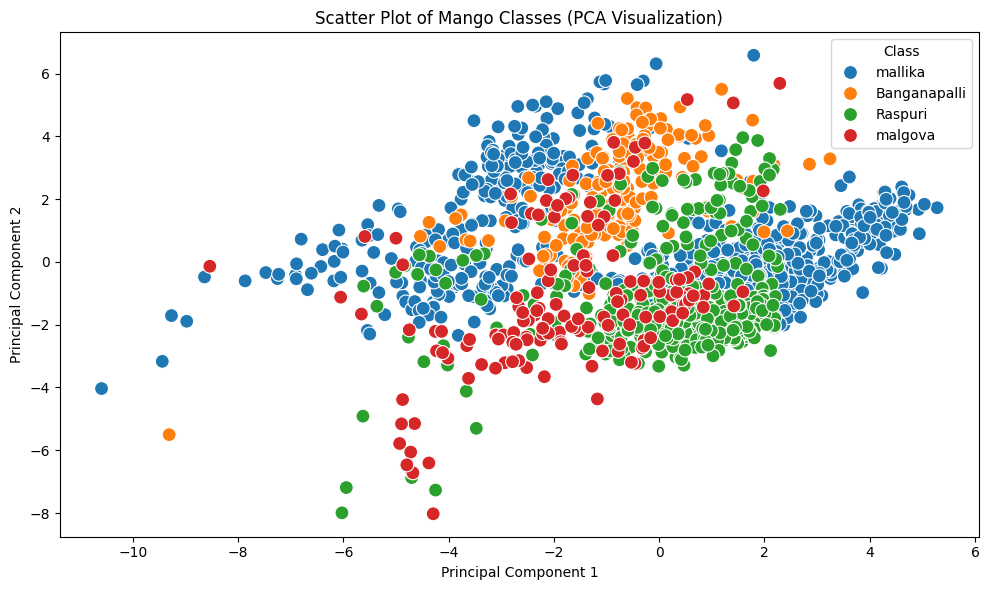

In [2]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

def plot_selected_classes_scatter(train_csv_path, selected_classes=None):
    # Load the training CSV file
    train_df = pd.read_csv(train_csv_path)

    # Identify feature columns (exclude 'img_name' and 'target')
    feature_columns = [col for col in train_df.columns if col not in ['image_name', 'target']]

    # Filter the DataFrame to include only the selected classes (if specified)
    if selected_classes is not None:
        train_df = train_df[train_df['target'].isin(selected_classes)]
        if train_df.empty:
            print(f"No data found for the selected classes: {selected_classes}")
            return

    # Extract features and true labels
    X = train_df[feature_columns].values
    true_labels = train_df['target'].values

    # Standardize the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Reduce dimensionality to 2D using PCA
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)

    # Create a DataFrame for visualization
    visual_df = pd.DataFrame({
        'PC1': X_pca[:, 0],
        'PC2': X_pca[:, 1],
        'True Label': true_labels
    })

    # Plot the scatter plot
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=visual_df, x='PC1', y='PC2', hue='True Label', s=100)
    plt.title(f'Scatter Plot of Mango Classes (PCA Visualization)')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend(title='Class')
    plt.tight_layout()
    plt.savefig('selected_classes_scatter_pca.png')
    plt.show()

if __name__ == "__main__":
    # Define the path to your CSV file
    train_csv_path = 'data/FE_data/raw_features_merged_data/train_csv.csv'

    
    selected_classes = ['mallika', 'Banganapalli','Raspuri','malgova']

    # Generate the scatter plot
    plot_selected_classes_scatter(train_csv_path, selected_classes)

5 class clustering including badami

In [ ]:
import os
import json
import joblib
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skfuzzy as fuzz

from itertools import cycle
from sklearn.preprocessing    import StandardScaler, label_binarize
from sklearn.cluster          import KMeans
from sklearn.mixture          import GaussianMixture
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.linear_model     import LogisticRegression
from sklearn.tree             import DecisionTreeClassifier
from sklearn.neighbors        import KNeighborsClassifier
from sklearn.base             import BaseEstimator, ClassifierMixin
from sklearn.model_selection  import StratifiedKFold, GridSearchCV
from sklearn.metrics          import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
    average_precision_score,
    confusion_matrix, ConfusionMatrixDisplay,
    roc_curve, auc,
    precision_recall_curve
)

warnings.filterwarnings("ignore", category=UserWarning)

# ───────────────────────────────────────────────────────────────────────────────
# Configuration
# ───────────────────────────────────────────────────────────────────────────────
TRAIN_CSV        = "data/FE_data/Train-test/train_balanced_dataset.csv"
TEST_CSV         = "data/FE_data/Train-test/val_no_outliers.csv"
TARGET           = "target"
EXCLUDE_CLASSES  = ["Badami"]
NON_FEATURES     = ["image_name"]
RAND             = 42
K_CLUSTERS       = 4
CV_FOLDS         = 5
SFS_MAX_FEATS    = 20
SAVE_DIR         = "saved_pipeline1"

os.makedirs(SAVE_DIR, exist_ok=True)

# ───────────────────────────────────────────────────────────────────────────────
# Custom GMMClassifier
# ───────────────────────────────────────────────────────────────────────────────
class GMMClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, n_components=1, covariance_type="full", random_state=None):
        self.n_components = n_components
        self.covariance_type = covariance_type
        self.random_state = random_state
    
    def fit(self, X, y):
        if hasattr(X, 'values'):
            X = X.values
        if hasattr(y, 'values'):
            y = y.values

        self.classes_, _ = np.unique(y, return_inverse=True)
        self.models_, self.priors_ = [], []

        for cls in self.classes_:
            mask = (y == cls)
            X_cls = X[mask]
            gmm = GaussianMixture(
                n_components=self.n_components,
                covariance_type=self.covariance_type,
                random_state=self.random_state
            ).fit(X_cls)
            self.models_.append(gmm)
            self.priors_.append(mask.mean())

        self.priors_ = np.array(self.priors_)
        return self
    
    def _joint_ll(self, X):
        if hasattr(X, 'values'):
            X = X.values
        return np.column_stack([
            mdl.score_samples(X) + np.log(p)
            for mdl, p in zip(self.models_, self.priors_)
        ])
    
    def predict_proba(self, X):
        ll = self._joint_ll(X)
        ll -= ll.max(1, keepdims=True)
        post = np.exp(ll)
        return post / post.sum(1, keepdims=True)
    
    def predict(self, X):
        ll = self._joint_ll(X)
        return self.classes_[np.argmax(ll, axis=1)]

# ───────────────────────────────────────────────────────────────────────────────
# Fuzzy C-means Clusterer
# ───────────────────────────────────────────────────────────────────────────────
class FuzzyCMeans:
    def __init__(self, n_clusters, m=2, error=0.005, maxiter=1000, random_state=None):
        self.n_clusters = n_clusters
        self.m = m
        self.error = error
        self.maxiter = maxiter
        self.random_state = random_state
        self.cntr = None
        self.u = None

    def fit(self, X):
        if hasattr(X, 'values'):
            X = X.values
        X = X.T  # skfuzzy expects (n_features, n_samples)
        self.cntr, self.u, _, _, _, _, _ = fuzz.cluster.cmeans(
            X, self.n_clusters, self.m, error=self.error, maxiter=self.maxiter, seed=self.random_state
        )
        return self

    def predict_memberships(self, X):
        if hasattr(X, 'values'):
            X = X.values
        X = X.T
        u, _, _, _, _, _ = fuzz.cluster.cmeans_predict(
            X, self.cntr, self.m, error=self.error, maxiter=self.maxiter
        )
        return u.T  # (n_samples, n_clusters)

# ───────────────────────────────────────────────────────────────────────────────
# Data loading helper
# ───────────────────────────────────────────────────────────────────────────────
def load_frame(path):
    df = pd.read_csv(path)
    if EXCLUDE_CLASSES:
        df = df[~df[TARGET].isin(EXCLUDE_CLASSES)]
    return df

train_df = load_frame(TRAIN_CSV)
test_df  = load_frame(TEST_CSV)

X_train = train_df.drop(columns=[TARGET])
y_train = train_df[TARGET]

X_test = test_df.drop(columns=[TARGET] + [
    c for c in NON_FEATURES if c in test_df
], errors="ignore")
y_test = test_df[TARGET]

# ───────────────────────────────────────────────────────────────────────────────
# Plotting utilities
# ───────────────────────────────────────────────────────────────────────────────
classes = np.unique(y_train)

def plot_conf(y_true, y_pred, title, fn):
    cm = confusion_matrix(y_true, y_pred, labels=classes)
    fig, ax = plt.subplots(figsize=(6,5))
    ConfusionMatrixDisplay(cm, display_labels=classes).plot(ax=ax, cmap=plt.cm.Blues)
    ax.set_title(title)
    plt.tight_layout()
    plt.savefig(fn)
    plt.close()

def plot_curves(y_true_bin, prob, title, pref):
    # ROC curves
    plt.figure(figsize=(7,6))
    for i, cls in enumerate(classes):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], prob[:, i])
        plt.plot(fpr, tpr, lw=2, label=f"{cls} (AUC={auc(fpr, tpr):.2f})")
    plt.plot([0,1],[0,1], 'k--')
    plt.title(f"{title} – ROC")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"{pref}_roc.png")
    plt.close()

    # Precision-Recall curves
    plt.figure(figsize=(7,6))
    for i, cls in enumerate(classes):
        pr, re, _ = precision_recall_curve(y_true_bin[:, i], prob[:, i])
        plt.plot(re, pr, lw=2, label=f"{cls} (AUC={auc(re, pr):.2f})")
    plt.title(f"{title} – PR")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"{pref}_pr.png")
    plt.close()

    # F1 vs Threshold
    plt.figure(figsize=(7,6))
    for i, (cls, col) in enumerate(zip(classes, cycle(plt.cm.tab10.colors))):
        pr, re, th = precision_recall_curve(y_true_bin[:, i], prob[:, i])
        f1 = 2 * pr * re / (pr + re + 1e-12)
        plt.plot(th, f1[:-1], lw=2, label=cls, color=col)
    plt.title(f"{title} – F1 vs Threshold")
    plt.xlabel("Threshold")
    plt.ylabel("F1-score")
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"{pref}_f1.png")
    plt.close()

# ───────────────────────────────────────────────────────────────────────────────
# Base models & grids
# ───────────────────────────────────────────────────────────────────────────────
base_models = {
    "LR" : LogisticRegression(max_iter=5000, solver="lbfgs"),
    "DT" : DecisionTreeClassifier(random_state=RAND),
    "KNN": KNeighborsClassifier(),
    "GMM": GMMClassifier(random_state=RAND)
}
param_grid = {
    "LR" : {"C": [0.1, 1, 10]},
    "DT" : {"max_depth": [None, 10, 20], "min_samples_split": [2, 5]},
    "KNN": {"n_neighbors": [4, 7, 10], "weights": ["uniform", "distance"], "p": [1, 2]},
    "GMM": {"n_components": [1, 2]}
}
cv_outer = StratifiedKFold(n_splits=CV_FOLDS, shuffle=True, random_state=RAND)

# ───────────────────────────────────────────────────────────────────────────────
# Main loop: one pipeline for each clusterer
# ───────────────────────────────────────────────────────────────────────────────
clusterers = {
    "kmeans": KMeans(n_clusters=K_CLUSTERS, random_state=RAND),
    "gmm"   : GaussianMixture(n_components=K_CLUSTERS, random_state=RAND),
    "fcm"   : FuzzyCMeans(n_clusters=K_CLUSTERS, random_state=RAND)
}

# Binarize once for all test-evaluations
y_test_bin = label_binarize(y_test, classes=classes)

orig_cols = X_train.columns.tolist()

for cname, clusterer in clusterers.items():
    print(f"\n=== Pipeline with {cname.upper()} clustering ===")

    # --- Prepare per-pipeline log dict ---
    pipeline_log = {}

    # 1. Fit scaler and clusterer on training data
    scaler = StandardScaler().fit(X_train)
    Xtr_s  = scaler.transform(X_train)
    clusterer.fit(Xtr_s)

    # 2. Augment train & test with cluster info
    if hasattr(clusterer, 'predict_memberships'):
        aug = clusterer.predict_memberships(Xtr_s)
        aug_cols = [f"{cname}_mem{i}" for i in range(K_CLUSTERS)]
    else:
        aug = clusterer.predict(Xtr_s).reshape(-1,1)
        aug_cols = [f"{cname}_lbl"]
    Xtr_aug = np.hstack([Xtr_s, aug])
    all_cols = orig_cols + aug_cols
    Xtr_df = pd.DataFrame(Xtr_aug, columns=all_cols)

    Xts_s = scaler.transform(X_test)
    if hasattr(clusterer, 'predict_memberships'):
        aug_test = clusterer.predict_memberships(Xts_s)
    else:
        aug_test = clusterer.predict(Xts_s).reshape(-1,1)
    Xts_aug = np.hstack([Xts_s, aug_test])
    Xts_df = pd.DataFrame(Xts_aug, columns=all_cols)

    # 3. Per-model SFS + hyperparameter tuning
    trained_models = {}
    model_feats    = {}
    cv_scores      = {}

    for mname, base_clf in base_models.items():
        print(f"  → Training {mname}…")
        # Sequential forward selection
        sfs = SFS(
            estimator=base_clf,
            k_features=(1, SFS_MAX_FEATS),
            forward=True,
            floating=False,
            scoring="accuracy",
            cv=cv_outer,
            n_jobs=-1
        ).fit(Xtr_df.values, y_train.values)

        feats = [all_cols[i] for i in sfs.k_feature_idx_]
        model_feats[mname] = feats

        # Grid search on selected features
        gs = GridSearchCV(
            base_clf, param_grid[mname],
            cv=cv_outer, scoring="accuracy",n_jobs=-1
        ).fit(Xtr_df[feats], y_train)

        trained_models[mname] = gs.best_estimator_
        cv_scores[mname]      = gs.best_score_

        # --- Log selected features and best hyperparameters ---
        pipeline_log[mname] = {
            "selected_features": feats,
            "best_hyperparameters": gs.best_params_,
            "cv_accuracy": gs.best_score_
        }

        print(f"     {mname}: {len(feats)} feats, CV acc = {gs.best_score_:.4f}, params = {gs.best_params_}")

    # 4. Persist this pipeline and its log
    bundle = {
        "scaler"      : scaler,
        "clusterer"   : clusterer,
        "aug_cols"    : aug_cols,
        "model_feats" : model_feats,
        "models"      : trained_models,
        "cv_scores"   : cv_scores
    }
    bundle_path = os.path.join(SAVE_DIR, f"{cname}_pipeline.joblib")
    joblib.dump(bundle, bundle_path)
    print(f"  ✔️ Saved bundle to {bundle_path}")

    # Write out the hyperparameter & feature‐selection log
    log_path = os.path.join(SAVE_DIR, f"{cname}_pipeline_log.json")
    with open(log_path, "w") as f:
        json.dump(pipeline_log, f, indent=2)
    print(f"  ✔️ Logged SFS features and best params to {log_path}")

    # 5. Load & evaluate on test set
    eval_dir = os.path.join(SAVE_DIR, cname)
    os.makedirs(eval_dir, exist_ok=True)

    bun = joblib.load(bundle_path)

    def preprocess_one(raw_X, bun):
        Xs = bun["scaler"].transform(raw_X)
        if hasattr(bun["clusterer"], 'predict_memberships'):
            aug = bun["clusterer"].predict_memberships(Xs)
        else:
            aug = bun["clusterer"].predict(Xs).reshape(-1,1)
        Xaug = np.hstack([Xs, aug])
        all_cols = orig_cols + bun["aug_cols"]
        return pd.DataFrame(Xaug, columns=all_cols)

    X_test_proc = preprocess_one(X_test, bun)

    for mname, clf in bun["models"].items():
        feats  = bun["model_feats"][mname]
        y_hat  = clf.predict(X_test_proc[feats])
        y_prob = clf.predict_proba(X_test_proc[feats])

        # compute metrics
        acc           = accuracy_score(y_test, y_hat)
        f1            = f1_score(y_test, y_hat, average='macro')
        precision     = precision_score(y_test, y_hat, average='macro')
        recall        = recall_score(y_test, y_hat, average='macro')
        roc_auc       = roc_auc_score(y_test_bin, y_prob,
                                     average='macro', multi_class='ovr')
        pr_auc        = average_precision_score(y_test_bin, y_prob,
                                                average='macro')

        # print metrics
        print(f"    {mname:3s} │ "
              f"Acc={acc:.4f} │ F1={f1:.4f} │ Prec={precision:.4f} │ "
              f"Rec={recall:.4f} │ ROC-AUC={roc_auc:.4f} │ PR-AUC={pr_auc:.4f}")

        # plots
        plot_conf(y_test, y_hat,
                  title=f"{cname.upper()} + {mname} Confusion",
                  fn=os.path.join(eval_dir, f"{mname}_cm.png"))
        plot_curves(y_test_bin, y_prob,
                    title=f"{cname.upper()} + {mname} Curves",
                    pref=os.path.join(eval_dir, mname))

    print(f"✅ Done evaluating pipeline with {cname.upper()} clustering.")